

#IDENTITHEM
_Synthesis Project_



*   Amelia Gómez Grabowska (1631745)
*   Sara Martín Nuñez (1669812)
*   Lara Rodríguez Cuenca (1667906)
*   Malaika Mbayo Michelle (1695157)
*   Aina Navarro Rafols (1670797)

# PART I: Data Exploration and Data Engineering

##Necessary libraries

In [1]:
!pip install apachelogs
!pip install user_agents
#!pip install -U spacy
#!python -m spacy download en_core_web_md
!pip install fasttext

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.4/73.4 kB 1.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached pybind11-2.12.0-py3-none-any.whl (234 kB)
  Created wheel for fasttext: filename=fasttext-0.9.3-cp310-cp310-linux_x86_64.whl size=4239662 sha256=29393aca53def7ab4a2f78ca709866b0959f2adc245cb07c58a5db29b726b04e
  Stored in directory: /root/.cache/pip/wheels/0d/a2/00/81db54d3e6a8199b829d58e02cec2ddb20ce3e59fad8d3c92a
Successfully built fasttext


In [2]:
import pandas as pd
import apachelogs
from apachelogs import LogParser
from google.colab import drive
from datetime import datetime
import re
import xml.etree.ElementTree as ET
import re
import os
import matplotlib.pyplot as plt
import seaborn as sns
from urllib.parse import urlparse
import requests
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import fasttext
import numpy as np
#import nltk
#nltk.download('punkt')
#import spacy

In [3]:
extracted_dir_path = '/content/Identithem'
if not os.path.exists(extracted_dir_path):
    !git clone https://github.com/Identithem/Identithem.git
else:
    print("Directory already exists.")

%cd "/content/Identithem"
!git pull

Cloning into 'Identithem'...
remote: Enumerating objects: 91, done.
remote: Counting objects: 100% (91/91), done.
remote: Compressing objects: 100% (83/83), done.
remote: Total 91 (delta 31), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (91/91), 79.88 MiB | 13.79 MiB/s, done.
Resolving deltas: 100% (31/31), done.
/content/Identithem
Already up to date.


In [4]:
# Create folder to store preprocessed data
folder_path = "/content/Identithem/preprocessed_data"
if not os.path.exists(folder_path):
    os.makedirs(folder_path)
    print(f"Folder '{folder_path}' created successfully.")
else:
    print(f"Folder '{folder_path}' already exists.")

Folder '/content/Identithem/preprocessed_data' created successfully.


##Import the data

In [5]:
parser = LogParser("%V %h %l %u %t \"%r\" %>s %b \"%{Referer}i\" \"%{User-Agent}i\"")

In [6]:
def parse_log(file):
  data = []
  with open(file) as fp:
    for line in fp:
      entry = parser.parse(line)
      e = [entry.directives["%h"], entry.directives["%l"], entry.directives["%u"], entry.directives["%t"], entry.directives["%r"], entry.directives["%>s"], entry.directives["%b"], entry.headers_in["Referer"], entry.headers_in["User-Agent"]]
      data.append(e)
  return pd.DataFrame(data, columns=['ip', 'client', 'user', 'datetime', 'request', 'status', 'size', 'referer', 'user_agent'])

In [7]:
extracted_dir_path = '/content/Identithem/SitgesLogs'
if not os.path.exists(extracted_dir_path):
    # If the directory does not exist, unzip the zip file
    %cd "/content/Identithem"
    !unzip -o "SitgesLogs.zip"
else:
    print("Directory already exists. Skipping unzip process.")


/content/Identithem
Archive:  SitgesLogs.zip
  inflating: Sitges Logs/sitges_access.20240122.log  
  inflating: Sitges Logs/sitges_access.20240123.log  
  inflating: Sitges Logs/sitges_access.20240124.log  
  inflating: Sitges Logs/sitges_access.20240125.log  
  inflating: Sitges Logs/sitges_access.20240126.log  
  inflating: Sitges Logs/sitges_access.20240127.log  
  inflating: Sitges Logs/sitges_access.20240128.log  
  inflating: Sitges Logs/sitges_access.20240129.log  


In [8]:
# Define a regular expression pattern to match IP addresses
ip_pattern = r'\b(?:\d{1,3}\.){3}\d{1,3}\b'

# Open the file and extract IP addresses
ip_addresses_blacklisted = []
with open('/content/Identithem/full_blacklist_database.txt', 'r') as file:
    for line in file:
        # Find all IP addresses in the line using the regular expression pattern
        ips_in_line = re.findall(ip_pattern, line)
        # Add the found IP addresses to the list
        ip_addresses_blacklisted.extend(ips_in_line)

# Print the list of IP addresses
print(len(ip_addresses_blacklisted))
ip_addresses_blacklisted = set(ip_addresses_blacklisted)
ip_addresses_blacklisted = {int(ip.replace('.', '')) for ip in ip_addresses_blacklisted}
print(len(ip_addresses_blacklisted))

229572
153412


##**DATA EXPLORATION I**

In [ ]:
df = parse_log('/content/Identithem/Sitges Logs/sitges_access.20240122.log')

###Number of request, bots and 404 errors per IP

In [ ]:
# counting how many times the user is logging into the computer with respect to ip address
requests_per_ip = df['ip'].value_counts().reset_index()
requests_per_ip = requests_per_ip.rename(columns={'count':'requests_per_ip'})

In [ ]:
is_bot = df['user_agent'].str.contains('bot|crawl|spider|ZmEu',case=False)
is_bot = is_bot.apply(lambda x: 1 if x else 0)

# Count the number of rows where 'bot' is present in the 'user_agent' column
count_bot = is_bot.groupby(df['ip']).sum()

count_bot = count_bot.reset_index()
count_bot = count_bot.rename(columns={'user_agent':'bots'})

In [ ]:
error404 = df[df['status'] == 404].groupby('ip').size()
error404 = error404.reset_index(name='num_404')

In [ ]:
df_ips = pd.merge(requests_per_ip, count_bot, on='ip', how='outer')
df_ips = pd.merge(df_ips, error404, on='ip', how='outer')
df_ips.fillna(0, inplace=True)
df_ips

,ip,requests_per_ip,bots,num_404
0,47.76.35.19,45227,0,277.0
1,176.9.10.174,3922,3922,576.0
2,216.244.66.199,3407,3407,3222.0
3,66.249.70.97,3161,3159,48.0
4,95.60.246.144,1590,0,0.0
...,...,...,...,...
3070,46.223.163.21,1,0,0.0
3071,40.77.202.139,1,1,0.0
3072,40.77.202.184,1,1,0.0
3073,98.122.164.214,1,0,0.0


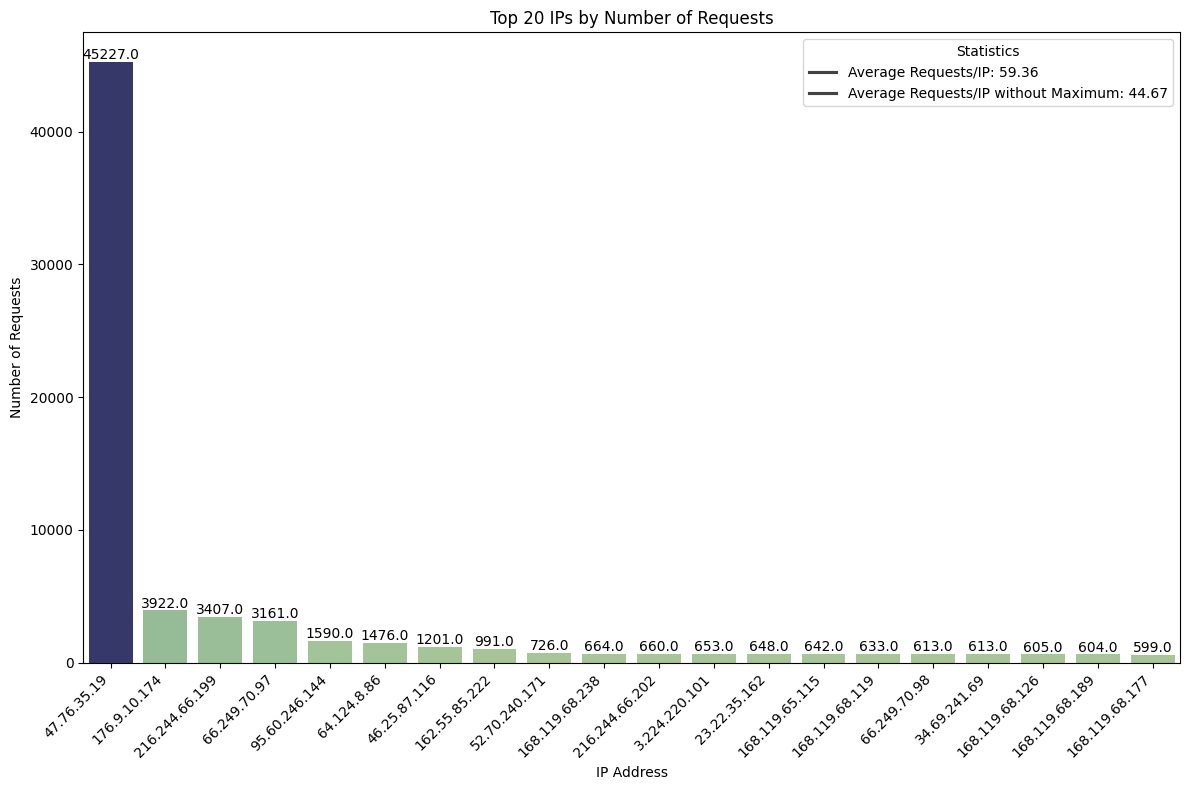

In [ ]:
# Plot IPs with more requests_per_ip
top_20_ips = df_ips.sort_values(by='requests_per_ip', ascending=False).head(20)
average_requests_per_ip = df_ips['requests_per_ip'].mean()
filtered_dfips = df_ips[df_ips['ip'] != "47.76.35.19"]
average_requests_per_ip2 = filtered_dfips['requests_per_ip'].mean()

plt.figure(figsize=(12, 8))
ax = sns.barplot(data=top_20_ips, x='ip', y='requests_per_ip', palette="crest",hue='requests_per_ip',legend=False)
for p in ax.patches:
    plt.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')
plt.title('Top 20 IPs by Number of Requests')
ax.legend(title='Statistics', labels=[f'Average Requests/IP: {average_requests_per_ip:.2f}',
                                     f'Average Requests/IP without Maximum: {average_requests_per_ip2:.2f}'])
plt.xlabel('IP Address')
plt.ylabel('Number of Requests')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

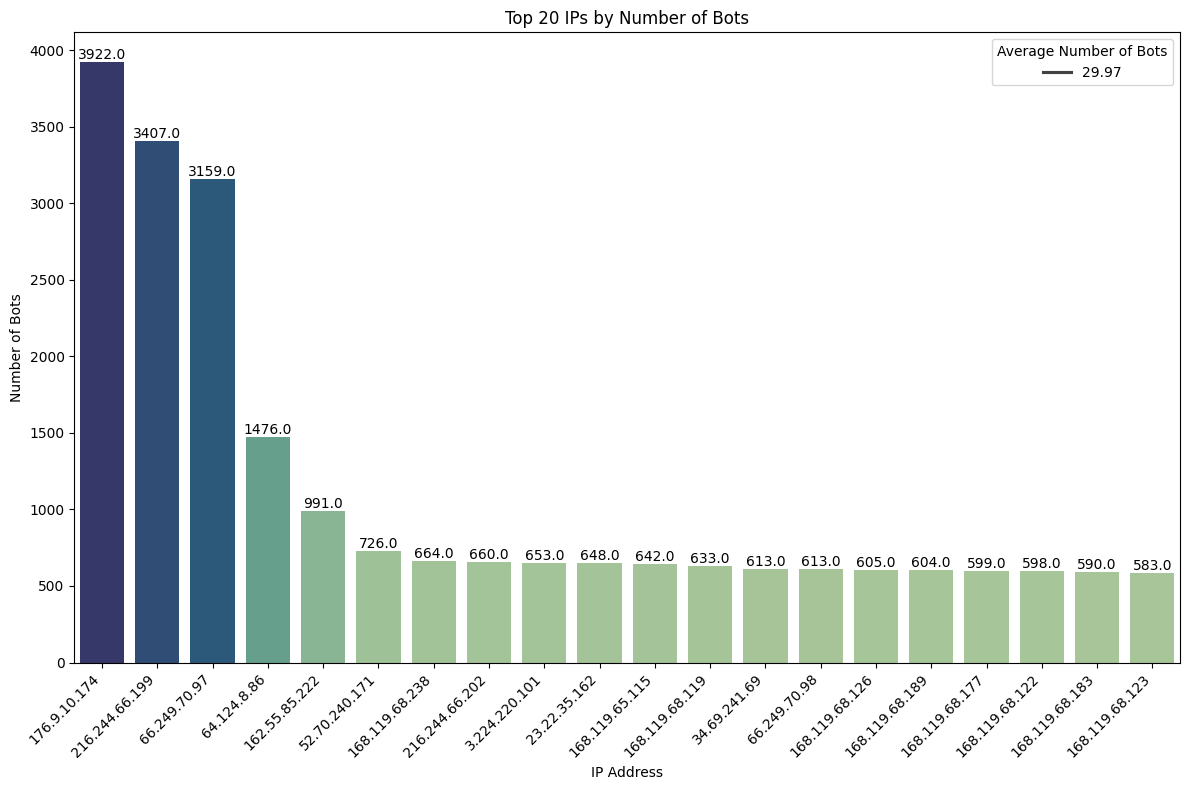

In [ ]:
# Plot IPs with more bots
top_20_ips = df_ips.sort_values(by='bots', ascending=False).head(20)
average_bots_per_ip = df_ips['bots'].mean()

plt.figure(figsize=(12, 8))
ax = sns.barplot(data=top_20_ips, x='ip', y='bots', palette="crest",hue='bots',legend=False)
for p in ax.patches:
    plt.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')
plt.title('Top 20 IPs by Number of Bots')
ax.legend(title='Average Number of Bots', labels=[f'{average_bots_per_ip:.2f}'])
plt.xlabel('IP Address')
plt.ylabel('Number of Bots')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

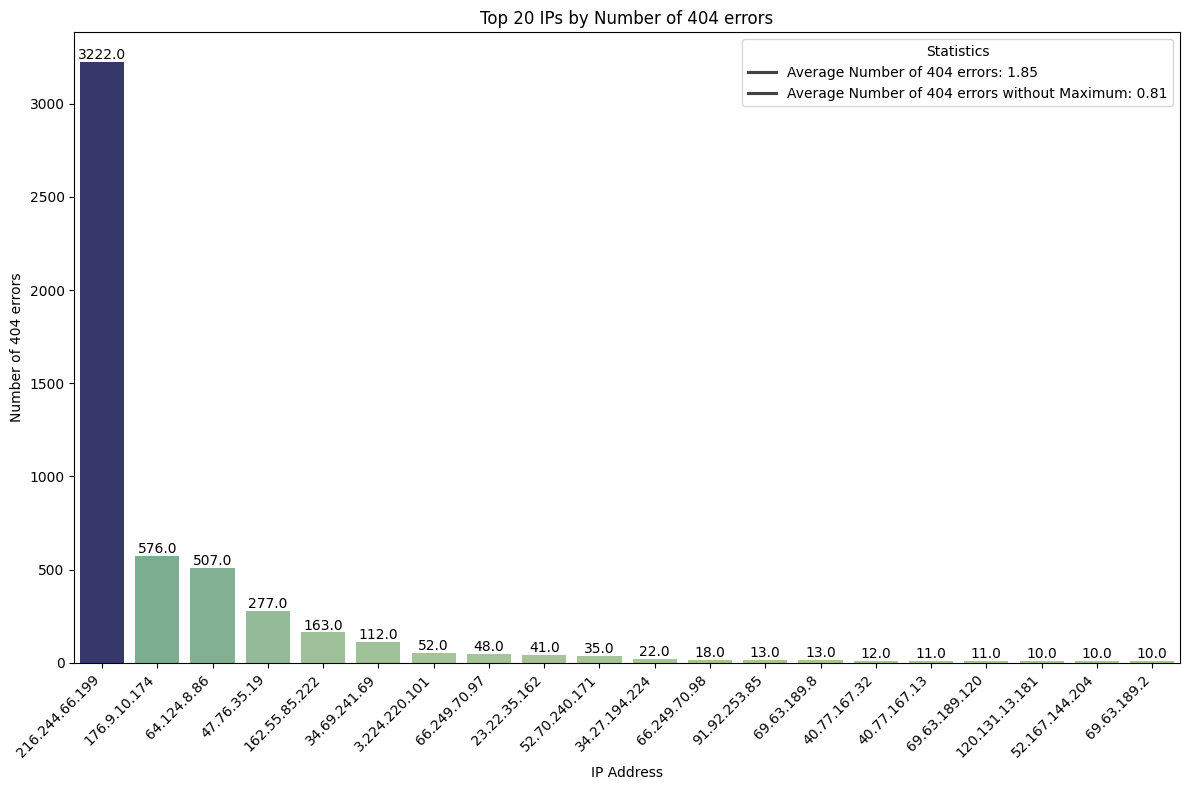

In [ ]:
# Plot IPs with more 404 errors
top_20_ips = df_ips.sort_values(by='num_404', ascending=False).head(20)
average_404_per_ip = df_ips['num_404'].mean()
filtered_dfips = df_ips[df_ips['ip'] != "216.244.66.199"]
average_404_per_ip2 = filtered_dfips['num_404'].mean()

plt.figure(figsize=(12, 8))
ax = sns.barplot(data=top_20_ips, x='ip', y='num_404', palette="crest",hue='num_404',legend=False)
for p in ax.patches:
    plt.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')
plt.title('Top 20 IPs by Number of 404 errors')
ax.legend(title='Statistics', labels=[f'Average Number of 404 errors: {average_404_per_ip:.2f}',
                                     f'Average Number of 404 errors without Maximum: {average_404_per_ip2:.2f}'])
plt.xlabel('IP Address')
plt.ylabel('Number of 404 errors')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

###Requests, unique requests and unique IPs per 10-second bucket

In [ ]:
# Convert 'datetime' column to datetime type
df['datetime'] = pd.to_datetime(df['datetime'])

# Round datetime to the nearest 10 seconds
df['datetime_10sec'] = df['datetime'].dt.round('10s')

# Group by rounded datetime
requests_per_10sec = df.groupby('datetime_10sec').size()
requests_per_10sec = requests_per_10sec.reset_index(name='requests_per_10sec')

In [ ]:
same_request_per_10sec = df.groupby('datetime_10sec')['request'].nunique().reset_index()
same_request_per_10sec.columns = ['datetime_10sec', 'unique_requests']

In [ ]:
same_ip_per_10sec = df.groupby('datetime_10sec')['ip'].nunique().reset_index()
same_ip_per_10sec.columns = ['datetime_10sec', 'unique_ips']

In [ ]:
df_10sec = pd.merge(requests_per_10sec, same_request_per_10sec, on='datetime_10sec')
df_10sec = pd.merge(df_10sec, same_ip_per_10sec, on='datetime_10sec')
df_10sec

,datetime_10sec,requests_per_10sec,unique_requests,unique_ips
0,2024-01-22 00:00:00+01:00,2,1,1
1,2024-01-22 00:00:10+01:00,9,3,2
2,2024-01-22 00:00:20+01:00,6,2,1
3,2024-01-22 00:00:30+01:00,11,7,3
4,2024-01-22 00:00:40+01:00,8,2,1
...,...,...,...,...
7911,2024-01-22 23:59:20+01:00,52,48,6
7912,2024-01-22 23:59:30+01:00,4,4,4
7913,2024-01-22 23:59:40+01:00,50,49,6
7914,2024-01-22 23:59:50+01:00,10,9,8


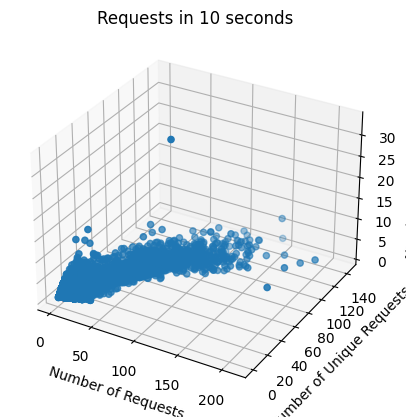

In [ ]:
# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df_10sec['requests_per_10sec'], df_10sec['unique_requests'], df_10sec['unique_ips'])
ax.set_title('Requests in 10 seconds')
ax.set_xlabel('Number of Requests')
ax.set_ylabel('Number of Unique Requests')
ax.set_zlabel('Number of Unique IPs')
plt.show()

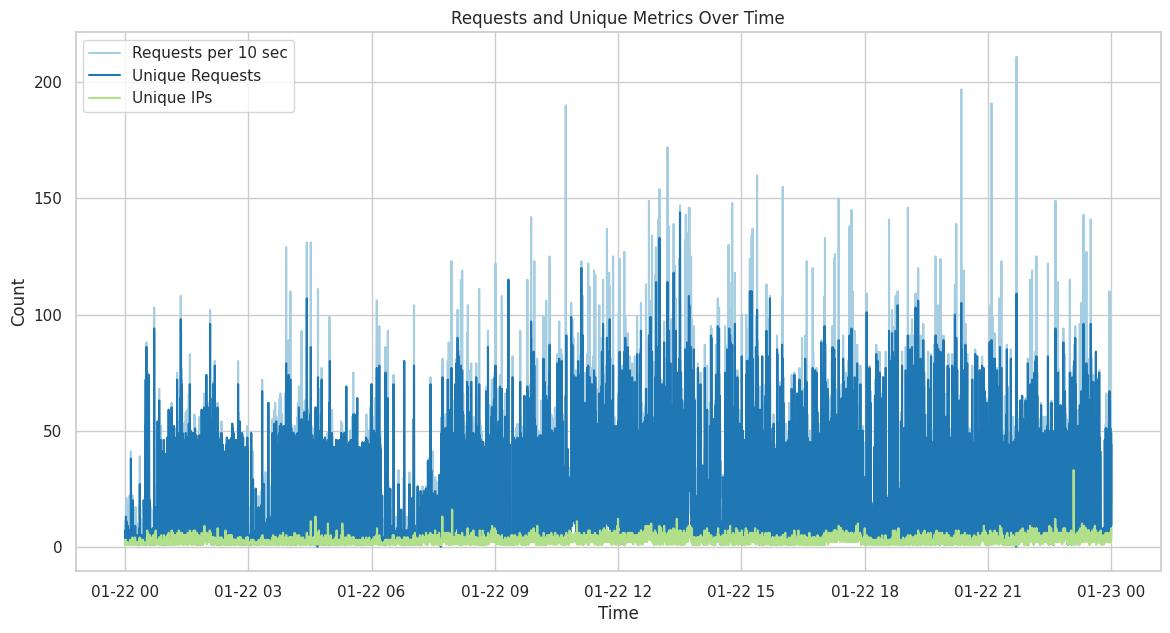

In [ ]:
# Plot time representation
df_10sec.set_index('datetime_10sec', inplace=True)
sns.set(style="whitegrid")
palette = sns.color_palette("Paired")

plt.figure(figsize=(14, 7))
plt.plot(df_10sec.index, df_10sec['requests_per_10sec'], label='Requests per 10 sec', color=palette[0])
plt.plot(df_10sec.index, df_10sec['unique_requests'], label='Unique Requests', color=palette[1])
plt.plot(df_10sec.index, df_10sec['unique_ips'], label='Unique IPs', color=palette[2])
plt.xlabel('Time')
plt.ylabel('Count')
plt.title('Requests and Unique Metrics Over Time')
plt.legend()
plt.show()

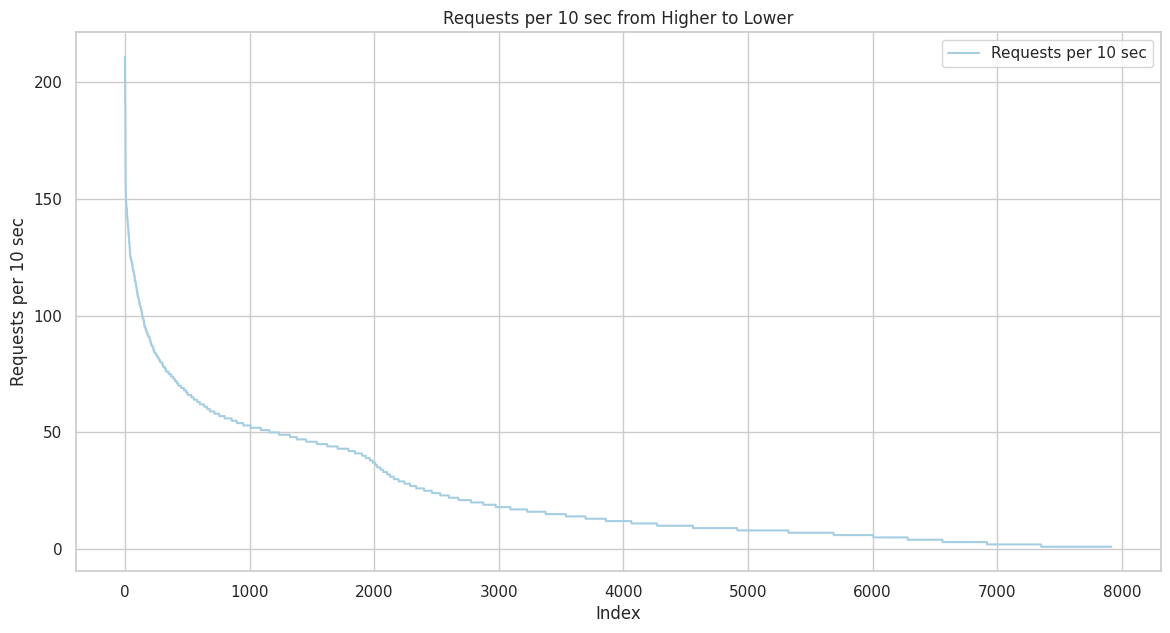

In [ ]:
# Plot time representation
df_10sec_sorted = df_10sec.sort_values(by='requests_per_10sec', ascending=False)
sns.set(style="whitegrid")
palette = sns.color_palette("Paired")

plt.figure(figsize=(14, 7))
plt.plot(df_10sec_sorted['requests_per_10sec'].reset_index(drop=True), label='Requests per 10 sec', color=palette[0])
plt.xlabel('Index')
plt.ylabel('Requests per 10 sec')
plt.title('Requests per 10 sec from Higher to Lower')
plt.legend()
plt.show()

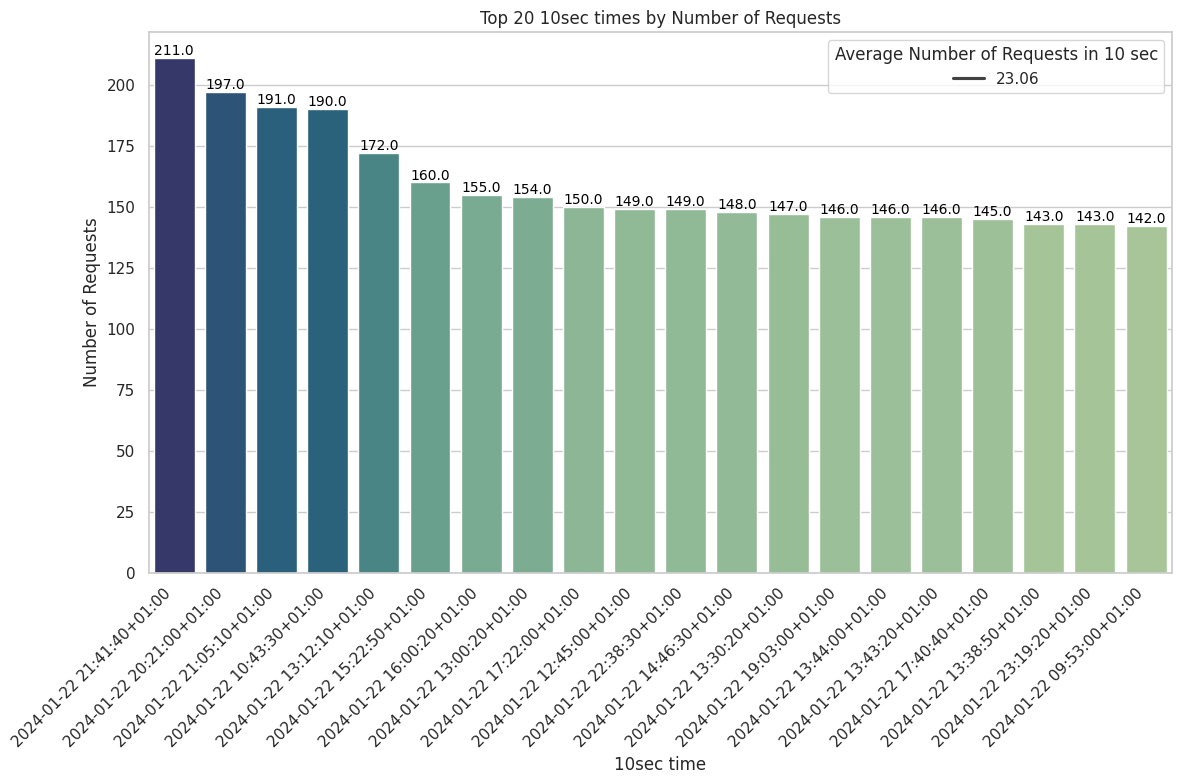

In [ ]:
# Plot time with more requests
top_20_time = df_10sec.sort_values(by='requests_per_10sec', ascending=False).head(20)
average_req_per_10sec = df_10sec['requests_per_10sec'].mean()

plt.figure(figsize=(12, 8))
ax = sns.barplot(data=top_20_time, x='datetime_10sec', y='requests_per_10sec', palette="crest",hue='requests_per_10sec',legend=False)
for p in ax.patches:
    plt.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')
plt.title('Top 20 10sec times by Number of Requests')
ax.legend(title='Average Number of Requests in 10 sec', labels=[f'{average_req_per_10sec:.2f}'])
plt.xlabel('10sec time')
plt.ylabel('Number of Requests')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

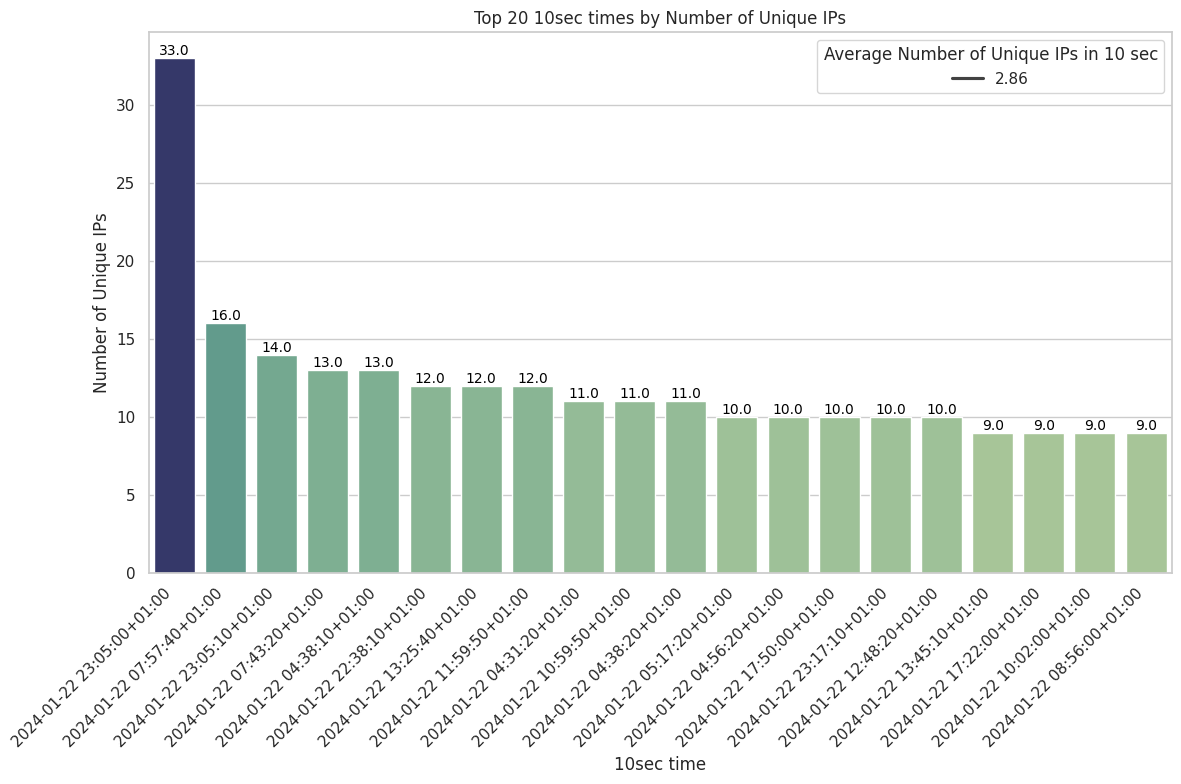

In [ ]:
# Plot time with more requests
top_20_time = df_10sec.sort_values(by='unique_ips', ascending=False).head(20)
average_ips_per_10sec = df_10sec['unique_ips'].mean()

plt.figure(figsize=(12, 8))
ax = sns.barplot(data=top_20_time, x='datetime_10sec', y='unique_ips', palette="crest",hue='unique_ips',legend=False)
for p in ax.patches:
    plt.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')
plt.title('Top 20 10sec times by Number of Unique IPs')
ax.legend(title='Average Number of Unique IPs in 10 sec', labels=[f'{average_ips_per_10sec:.2f}'])
plt.xlabel('10sec time')
plt.ylabel('Number of Unique IPs')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

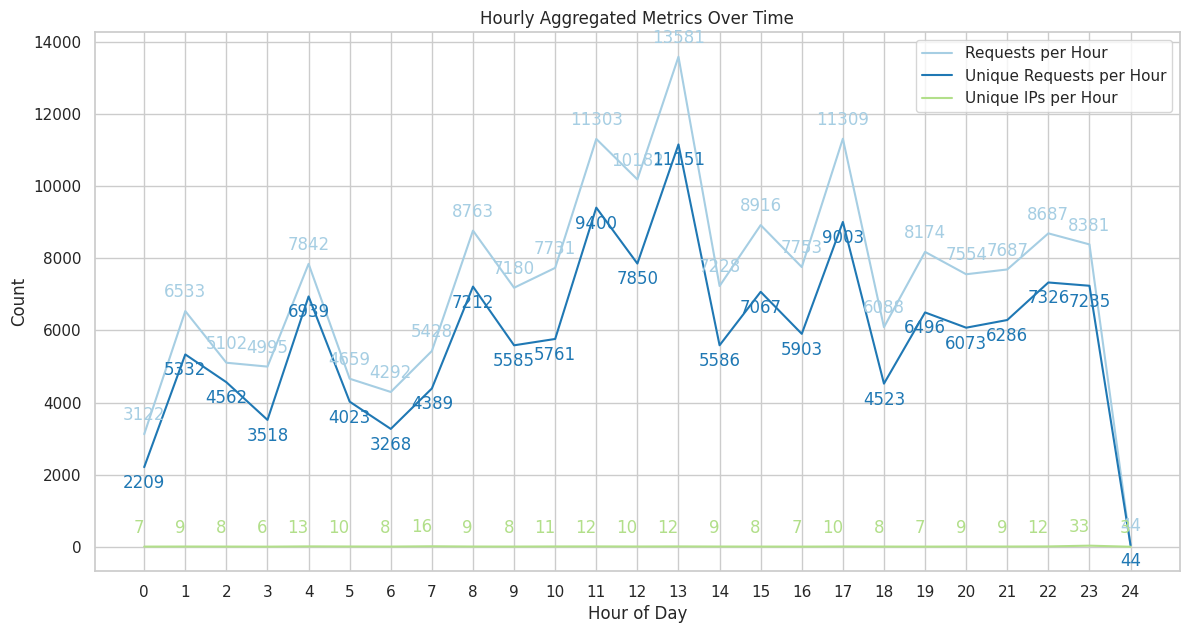

In [ ]:
# Resample the data by hour and aggregate using sum for requests and unique requests, and max for unique IPs
df_hourly = df_10sec.resample('H').agg({
    'requests_per_10sec': 'sum',
    'unique_requests': 'sum',
    'unique_ips': 'max'})

df_hourly.reset_index(inplace=True)

sns.set(style="whitegrid")
palette = sns.color_palette("Paired")

plt.figure(figsize=(14, 7))
plt.plot(df_hourly.index, df_hourly['requests_per_10sec'], label='Requests per Hour', color=palette[0])
plt.plot(df_hourly.index, df_hourly['unique_requests'], label='Unique Requests per Hour', color=palette[1])
plt.plot(df_hourly.index, df_hourly['unique_ips'], label='Unique IPs per Hour', color=palette[2])
plt.xlabel('Hour of Day')
plt.ylabel('Count')
plt.title('Hourly Aggregated Metrics Over Time')
plt.legend()
for i in range(len(df_hourly)):
    plt.annotate(f"{df_hourly['requests_per_10sec'][i]}",
                 (df_hourly.index[i], df_hourly['requests_per_10sec'][i]),
                 textcoords="offset points", xytext=(0,10), ha='center', color=palette[0])
    plt.annotate(f"{df_hourly['unique_requests'][i]}",
                 (df_hourly.index[i], df_hourly['unique_requests'][i]),
                 textcoords="offset points", xytext=(0,-15), ha='center', color=palette[1])
    plt.annotate(f"{df_hourly['unique_ips'][i]}",
                 (df_hourly.index[i], df_hourly['unique_ips'][i]),
                 textcoords="offset points", xytext=(0,10), ha='right', color=palette[2])
plt.xticks(range(25))
plt.show()

###Status classification

In [ ]:
# checking how many status we have and classify them
status_values = df['status'].unique()
status_values

array([301, 200, 404, 206, 408, 304, 403, 400, 302, 401])

Meaning of status codes:

*   200: OK --> The request succeeded. Returned information
depends on the method, used in request.

*   206: PARTIAL CONTENT --> The request has succeeded and the body contains the requested ranges of data, as described in the Range header of the request.

*   301: MOVED PERMANENTLY --> The resource was moved, and the
current and future requests should use one of the
returned URLs.

*   302: FOUND --> Indicates that requested resource was
temporarily moved to another URL.

*   304: NOT MODIFIED --> There is no need to retransmit the requested resources.

*   400: BAD REQUEST --> Means that the request wasn't understood due to
malformed syntax.

*   401: UNAUTHORIZED --> Used when authentication is needed, but got
failed or wasn't provided.

*   403: FORBIDDEN --> Usually appears, when user has no permissions
to request the resource.

*   404: NOT FOUND --> Indicates that server couldn't find anything
matching to the requested URL. The file doesn't
exist at given address.

*   408: REQUEST TIMEOUT --> Indicates that server shuts down the unused
connection.



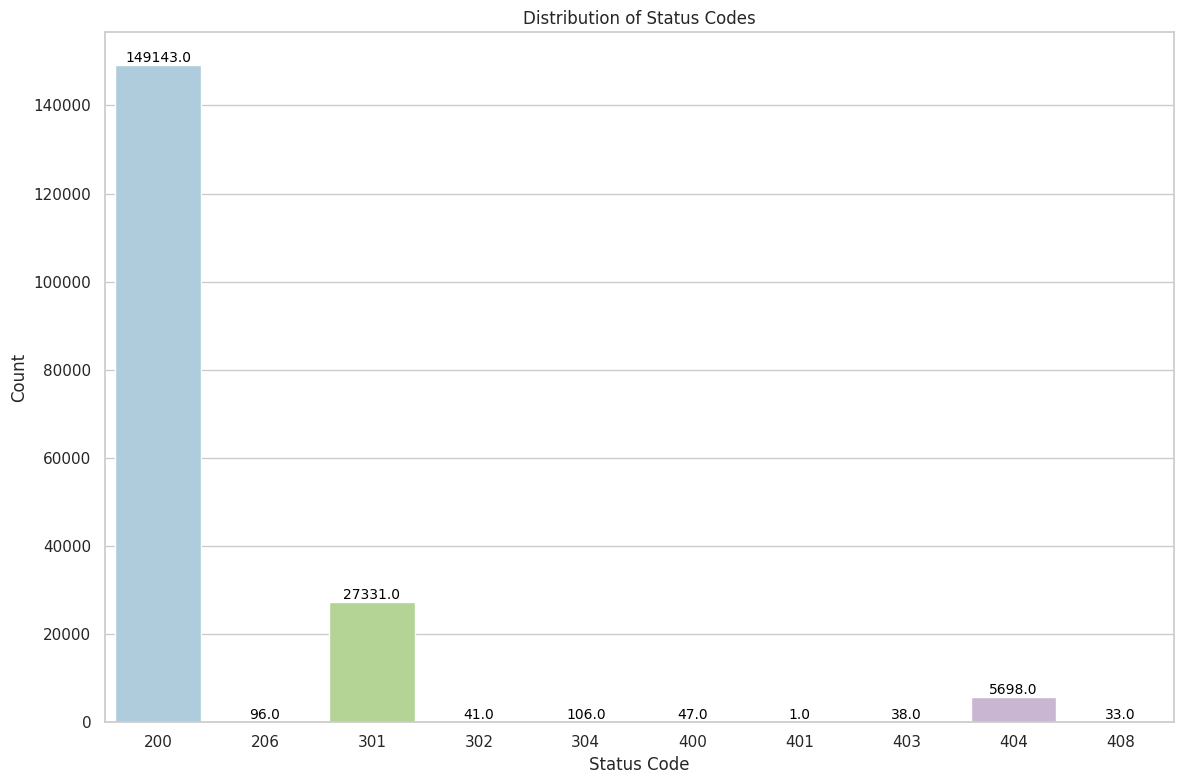

In [ ]:
# Create count plot
plt.figure(figsize=(12, 8))
ax = sns.countplot(data=df, x='status', palette="Paired",hue='status',legend=False)
for p in ax.patches:
    plt.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')
plt.title('Distribution of Status Codes')
plt.xlabel('Status Code')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

### Nan Values

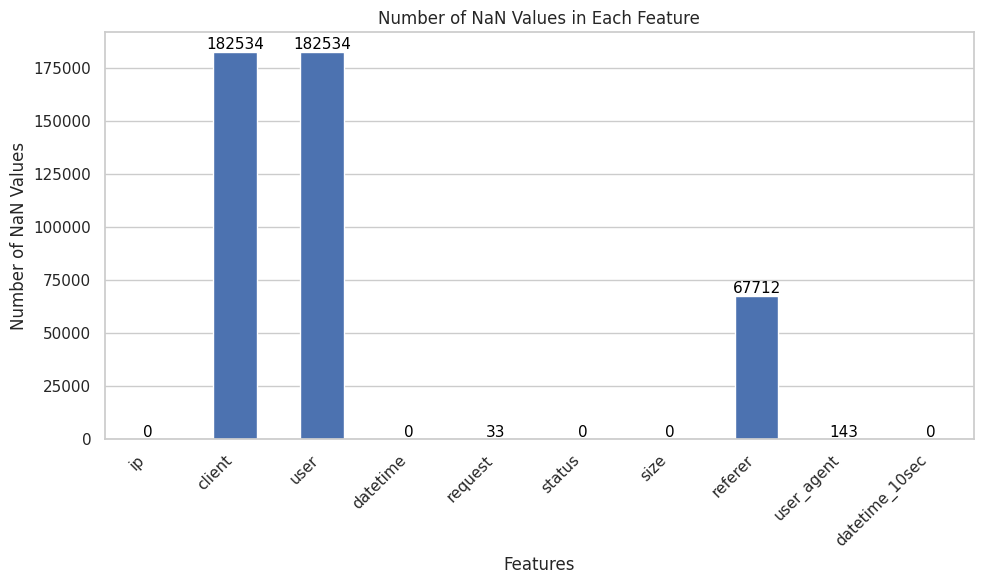

In [ ]:
nan_counts = df.isnull().sum()
plt.figure(figsize=(10, 6))
ax = nan_counts.plot(kind='bar')
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=11, color='black', xytext=(0, 5),
                textcoords='offset points')
plt.title('Number of NaN Values in Each Feature')
ax.grid(axis="x")
plt.xlabel('Features')
plt.ylabel('Number of NaN Values')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
# NaN rows
has_nan = df.isnull().any(axis=1)
df_with_nan = df[has_nan]

In [ ]:
df['referer'].eq('-').any()
# are NaN values equivalent to '-' (user accessed directly)?

False

In [ ]:
# Check which are the features that have nan values
print("Ip feature has Nan: ",df_with_nan['ip'].isnull().any())
print("Datetime feature has Nan: ",df_with_nan['datetime'].isnull().any())
print("Request feature has Nan: ",df_with_nan['request'].isnull().any())
print("Status feature has Nan: ",df_with_nan['status'].isnull().any())
print("Size feature has Nan: ",df_with_nan['size'].isnull().any())
print("Referer feature has Nan: ",df_with_nan['referer'].isnull().any())
print("User agent feature has Nan: ",df_with_nan['user_agent'].isnull().any())

Ip feature has Nan:  False
Datetime feature has Nan:  False
Request feature has Nan:  True
Status feature has Nan:  False
Size feature has Nan:  False
Referer feature has Nan:  True
User agent feature has Nan:  True


In [ ]:
# Check if there are examples that have Nan values in more than one feature
examples_with_multiple_nans = df_with_nan[df_with_nan.isnull().sum(axis=1) > 1]
print("Rows with more than 1 NaN value:",len(examples_with_multiple_nans))

# Find combinations of features with NaN values
nan_combinations = []
for index, row in df_with_nan.iterrows():
    nan_features = row[row.isnull()].index.tolist()
    if (len(nan_features) > 0) and (nan_features not in nan_combinations):
        nan_combinations.append(nan_features)
print("NaN possible combinations: ",nan_combinations)

Rows with more than 1 NaN value: 182534
NaN possible combinations:  [['client', 'user', 'referer'], ['client', 'user'], ['client', 'user', 'referer', 'user_agent'], ['client', 'user', 'request', 'referer', 'user_agent'], ['client', 'user', 'user_agent']]


In [ ]:
# Store examples with the same feature of nan in different datasets
df_request_nans = df[has_nan & (df['request'].isnull()) & (df.isnull().sum(axis=1) == 1)]
df_user_agent_nans = df[has_nan & (df['user_agent'].isnull()) & (df.isnull().sum(axis=1) == 1)]
df_referer_nans = df[has_nan & (df['referer'].isnull()) & (df.isnull().sum(axis=1) == 1)]
df_refanduser_nans = df[has_nan & (df['user_agent'].isnull()) & (df["referer"].isnull()) & (df.isnull().sum(axis=1) == 2)]
df_all3_nans = df[has_nan & (df['user_agent'].isnull()) & (df["referer"].isnull()) & (df['request'].isnull()) & (df.isnull().sum(axis=1) == 3)]

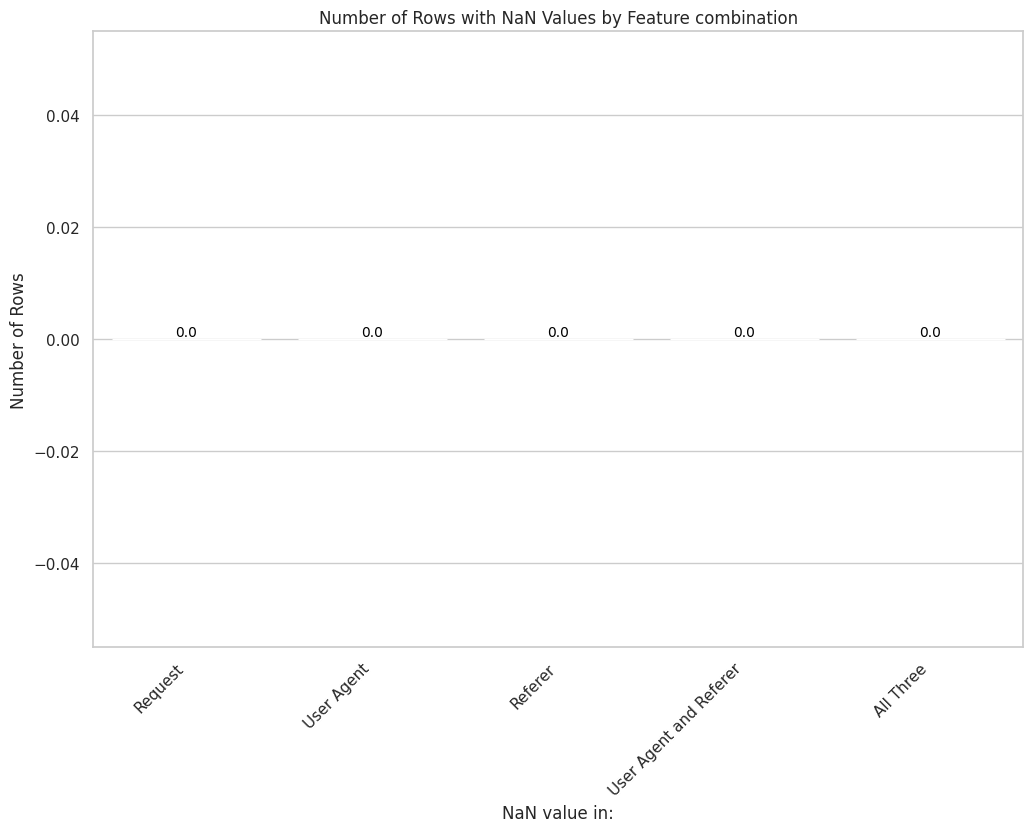

In [ ]:
# Plot
dfs = [df_request_nans, df_user_agent_nans, df_referer_nans, df_refanduser_nans, df_all3_nans]
labels = ['Request', 'User Agent', 'Referer', 'User Agent and Referer', 'All Three']
rows_counts = [len(df) for df in dfs]

plt.figure(figsize=(12, 8))
ax = sns.barplot(x=labels, y=rows_counts, palette="Paired",hue=rows_counts,legend=False)
for p in ax.patches:
    plt.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')
plt.title('Number of Rows with NaN Values by Feature combination')
plt.xlabel('NaN value in:')
plt.ylabel('Number of Rows')
plt.xticks(rotation=45, ha='right')
plt.show()

### Request

In [ ]:
def extract_path(request):
    if request == None:
        return None
    path = request.split()[1:-1]
    if len(path) > 0:
        path = path[0]
    else:
        path = "unknown"
    return path

req_verb = df["request"].apply(lambda x: x.split()[0] if x is not None else "unknown")
req_path = df['request'].apply(lambda x: extract_path(x) if x is not None else "unknown")
req_http = df["request"].apply(lambda x: x.split()[-1] if x is not None else "unknown")

print("Unique verb values in request: ",req_verb.unique())
print("Unique HTTP values in request: ",req_http.unique())

Unique verb values in request:  ['HEAD' 'GET' 'POST' 'unknown' '\x16\x03\x01' '\x18\x99^lqºð`\x10\x04°Àã'
 '.»\x05ïFþR' 'CONNECT' 'OPTIONS' '\x16\x03\x01\x01H\x01'
 '\x16\x03\x01\x06¾\x01' '\x16\x03\x01\x06Þ\x01' '\x16\x03\x01\x07'
 '\x16\x03\x01\x06þ\x01' 'MGLNDD_91.134.184.72_80' '\x03'
 'c±Uú\x88øû«`\x10\x04°ö\\' "+>è*9\x8aÂ'`\x11\x04°\xad³" '0']
Unique HTTP values in request:  ['HTTP/1.1' 'HTTP/2.0' 'HTTP/1.0' 'unknown' '\x16\x03\x01'
 '\x18\x99^lqºð`\x10\x04°Àã' '`\x10\x04°Ú[' '\x16\x03\x01\x01H\x01'
 '\x16\x03\x01\x06¾\x01' '\x16\x03\x01\x06Þ\x01' '\x01'
 '\x16\x03\x01\x06þ\x01' 'MGLNDD_91.134.184.72_80' '\x03'
 'c±Uú\x88øû«`\x10\x04°ö\\' "+>è*9\x8aÂ'`\x11\x04°\xad³" '0']


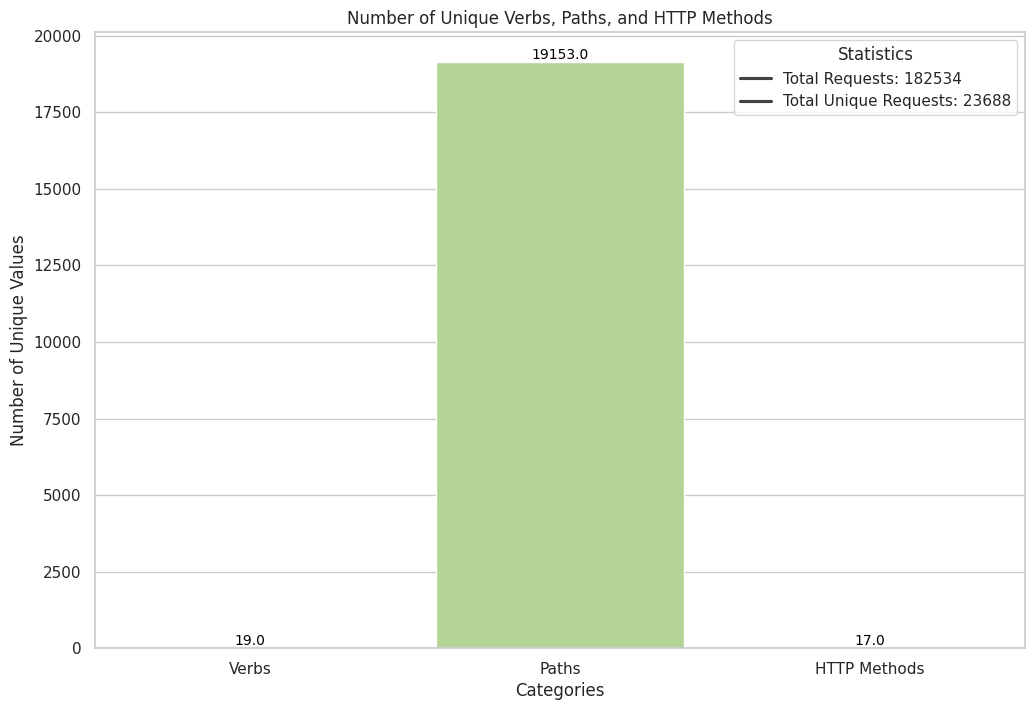

In [ ]:
uniques = [req_verb.nunique(), req_path.nunique(), req_http.nunique()]

sns.set(style="whitegrid")
palette = sns.color_palette("Paired")

plt.figure(figsize=(12, 8))
ax = sns.barplot(x=['Verbs', 'Paths', 'HTTP Methods'], y=uniques, palette="Paired",hue=uniques,legend=False)
for p in ax.patches:
    plt.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')
plt.xlabel('Categories')
plt.ylabel('Number of Unique Values')
plt.title('Number of Unique Verbs, Paths, and HTTP Methods')
total_requests = len(df["request"])
total_unique_requests = len(df["request"].unique())
legend_labels = [f'Total Requests: {total_requests}', f'Total Unique Requests: {total_unique_requests}']
plt.legend(title='Statistics', labels=legend_labels, loc='upper right')
plt.show()

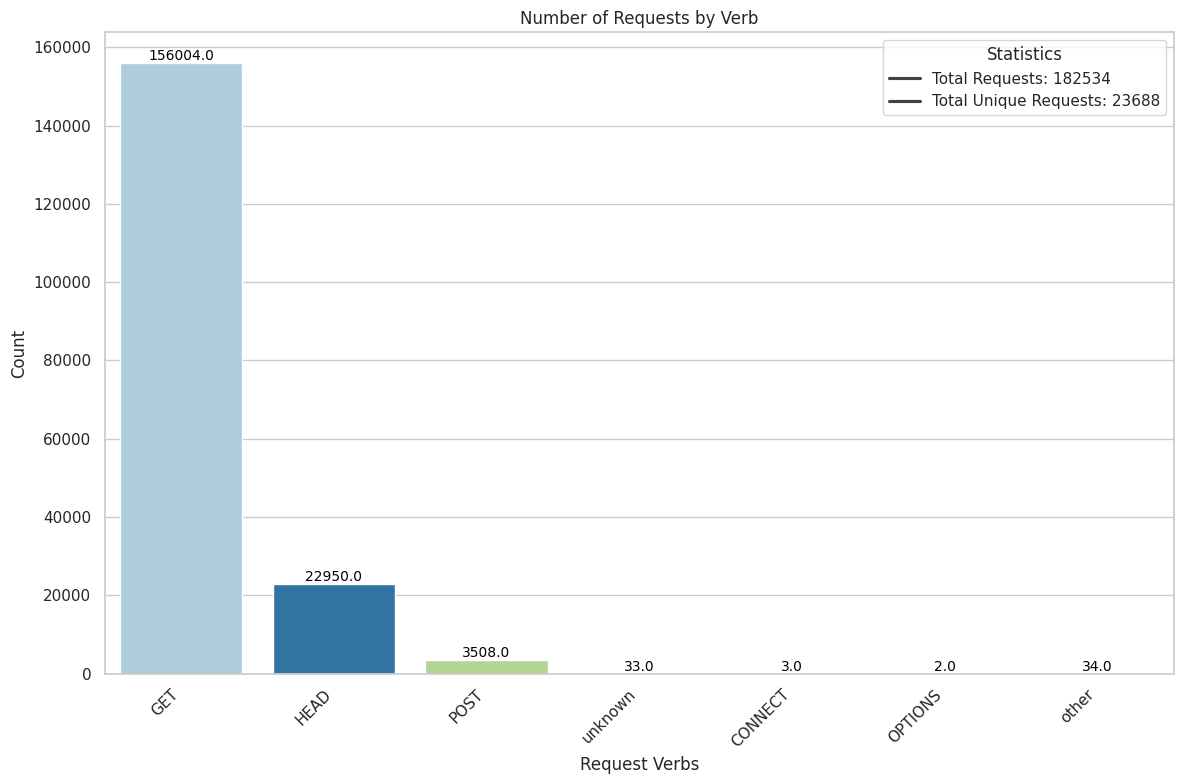

In [ ]:
# Plot verb types
specific_categories = ['HEAD', 'GET', 'POST', 'CONNECT', 'OPTIONS', 'unknown']
specific_category_counts = req_verb[req_verb.isin(specific_categories)].value_counts()
other_category_count = (req_verb[~req_verb.isin(specific_categories)]).count()
category_counts = pd.concat([specific_category_counts, pd.Series({'other': other_category_count})])

plt.figure(figsize=(12, 8))
ax = sns.barplot(x=category_counts.index, y=category_counts.values, palette="Paired", hue=category_counts.index, legend=False)
for p in ax.patches:
    plt.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')
plt.xlabel('Request Verbs')
plt.ylabel('Count')
plt.title('Number of Requests by Verb')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
total_requests = len(df["request"])
total_unique_requests = len(df["request"].unique())
legend_labels = [f'Total Requests: {total_requests}', f'Total Unique Requests: {total_unique_requests}']
plt.legend(title='Statistics', labels=legend_labels, loc='upper right')
plt.show()

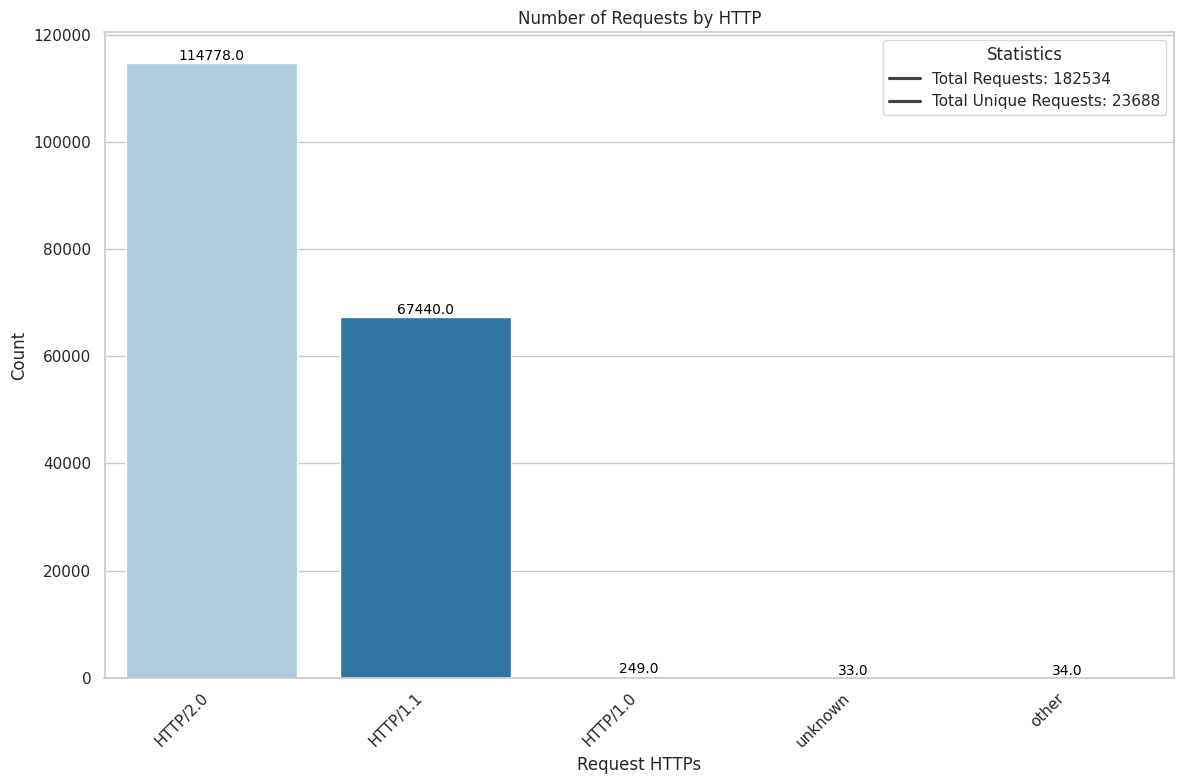

In [ ]:
# Plot http types
specific_categories = ['HTTP/1.1','HTTP/2.0','HTTP/1.0','unknown']
specific_category_counts = req_http[req_http.isin(specific_categories)].value_counts()
other_category_count = (req_http[~req_http.isin(specific_categories)]).count()
category_counts = pd.concat([specific_category_counts, pd.Series({'other': other_category_count})])

plt.figure(figsize=(12, 8))
ax = sns.barplot(x=category_counts.index, y=category_counts.values, palette="Paired", hue=category_counts.index, legend=False)
for p in ax.patches:
    plt.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')
plt.xlabel('Request HTTPs')
plt.ylabel('Count')
plt.title('Number of Requests by HTTP')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
total_requests = len(df["request"])
total_unique_requests = len(df["request"].unique())
legend_labels = [f'Total Requests: {total_requests}', f'Total Unique Requests: {total_unique_requests}']
plt.legend(title='Statistics', labels=legend_labels, loc='upper right')
plt.show()

### Referer

In [ ]:
# Extract scheme, netloc, and path components from the referer column
ref_schemes = df['referer'].apply(lambda x: urlparse(x).scheme if x is not None else None)
ref_domains = df['referer'].apply(lambda x: urlparse(x).netloc if x is not None else None)
ref_paths = df['referer'].apply(lambda x: urlparse(x).path if x is not None else None)

print("Unique schemes:", ref_schemes.unique())
print("Unique domains:", ref_domains.unique())
print("Number of unique paths:", ref_paths.nunique())

Unique schemes: [None 'https' 'http' '' 'android-app']
Unique domains: [None 'www.google.com' 'www.sitgesanytime.com' 'ip72.ip-91-134-184.eu'
 'www.bing.com' 'www.google.es' 'flo.uri.sh' 'www.sitgestur.cat'
 'sitgestur.info' 'www.sitgesfilmoffice.es' 'www.sitgesfilmoffice.cat'
 '91.134.184.72' 'co.images.search.yahoo.com' 'www.bestsitges.net'
 'www.bestsitges.es' 'ww.sitgesfilmoffice.es' 'www.sitgesanytime.cat'
 'www.sitgesweddings.cat' 'www.bestsitges.cat' 'designboxtech.com'
 'www.google.co.uk' 'sitgestur.cat' 'sitgesanytime.com' 'www.google.ie'
 'mavink.com' 'www.sitgesfilmoffice.com' 'www.bestsitges.com'
 'sitgesanytime.org' 'sitgestur.org' 'www.sitgesanytime.com:443'
 'sitgestur.net' 'www.sitgestur.net' '91.134.184.72:80' 'ds.ubintia.com'
 'myactivity.google.com' 'www.google.nl' 'www.hitree.shop' 'www.google.de'
 'www.radiomaricel.cat' 'webmail.sitgesfilmoffice.cat' 'www.google.fr'
 'm.facebook.com' 'secure-web.cisco.com' '91.134.184.72:443'
 'www.ecosia.org' 'elc-law.de' 'www.goo

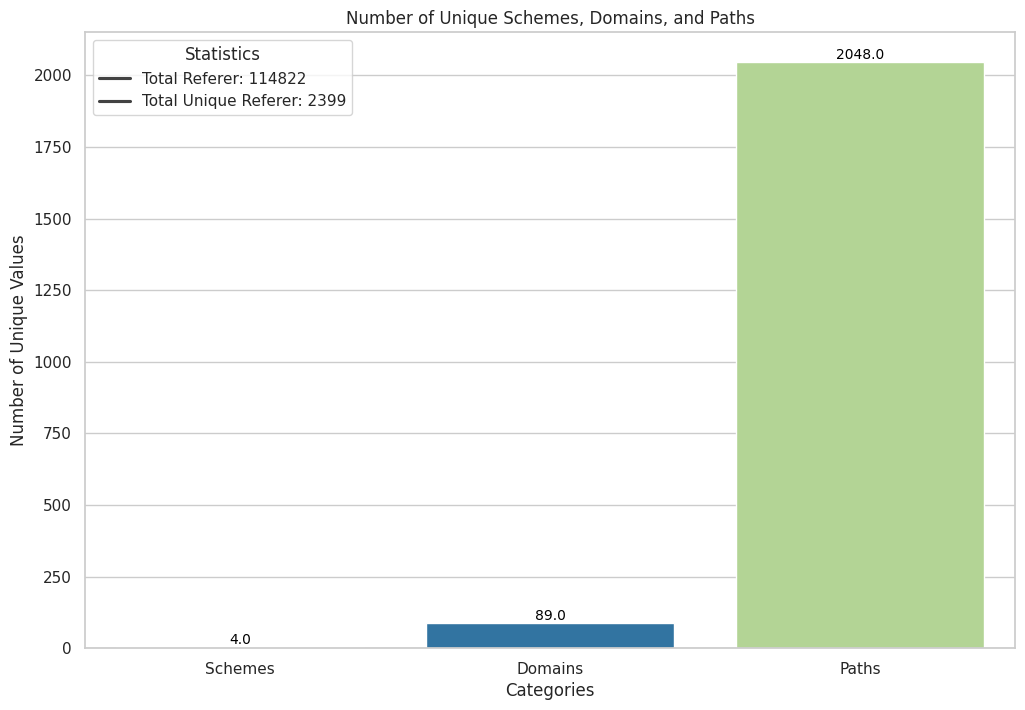

In [ ]:
uniques = [ref_schemes.nunique(), ref_domains.nunique(), ref_paths.nunique()]

sns.set(style="whitegrid")
palette = sns.color_palette("Paired")

plt.figure(figsize=(12, 8))
ax = sns.barplot(x=['Schemes', 'Domains', 'Paths'], y=uniques, palette="Paired",hue=uniques,legend=False)
for p in ax.patches:
    plt.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')
plt.xlabel('Categories')
plt.ylabel('Number of Unique Values')
plt.title('Number of Unique Schemes, Domains, and Paths')
total_referer = df['referer'].notna().sum()
total_unique_referer = len(df["referer"].unique())
legend_labels = [f'Total Referer: {total_referer}', f'Total Unique Referer: {total_unique_referer}']
plt.legend(title='Statistics', labels=legend_labels, loc='upper left')
plt.show()

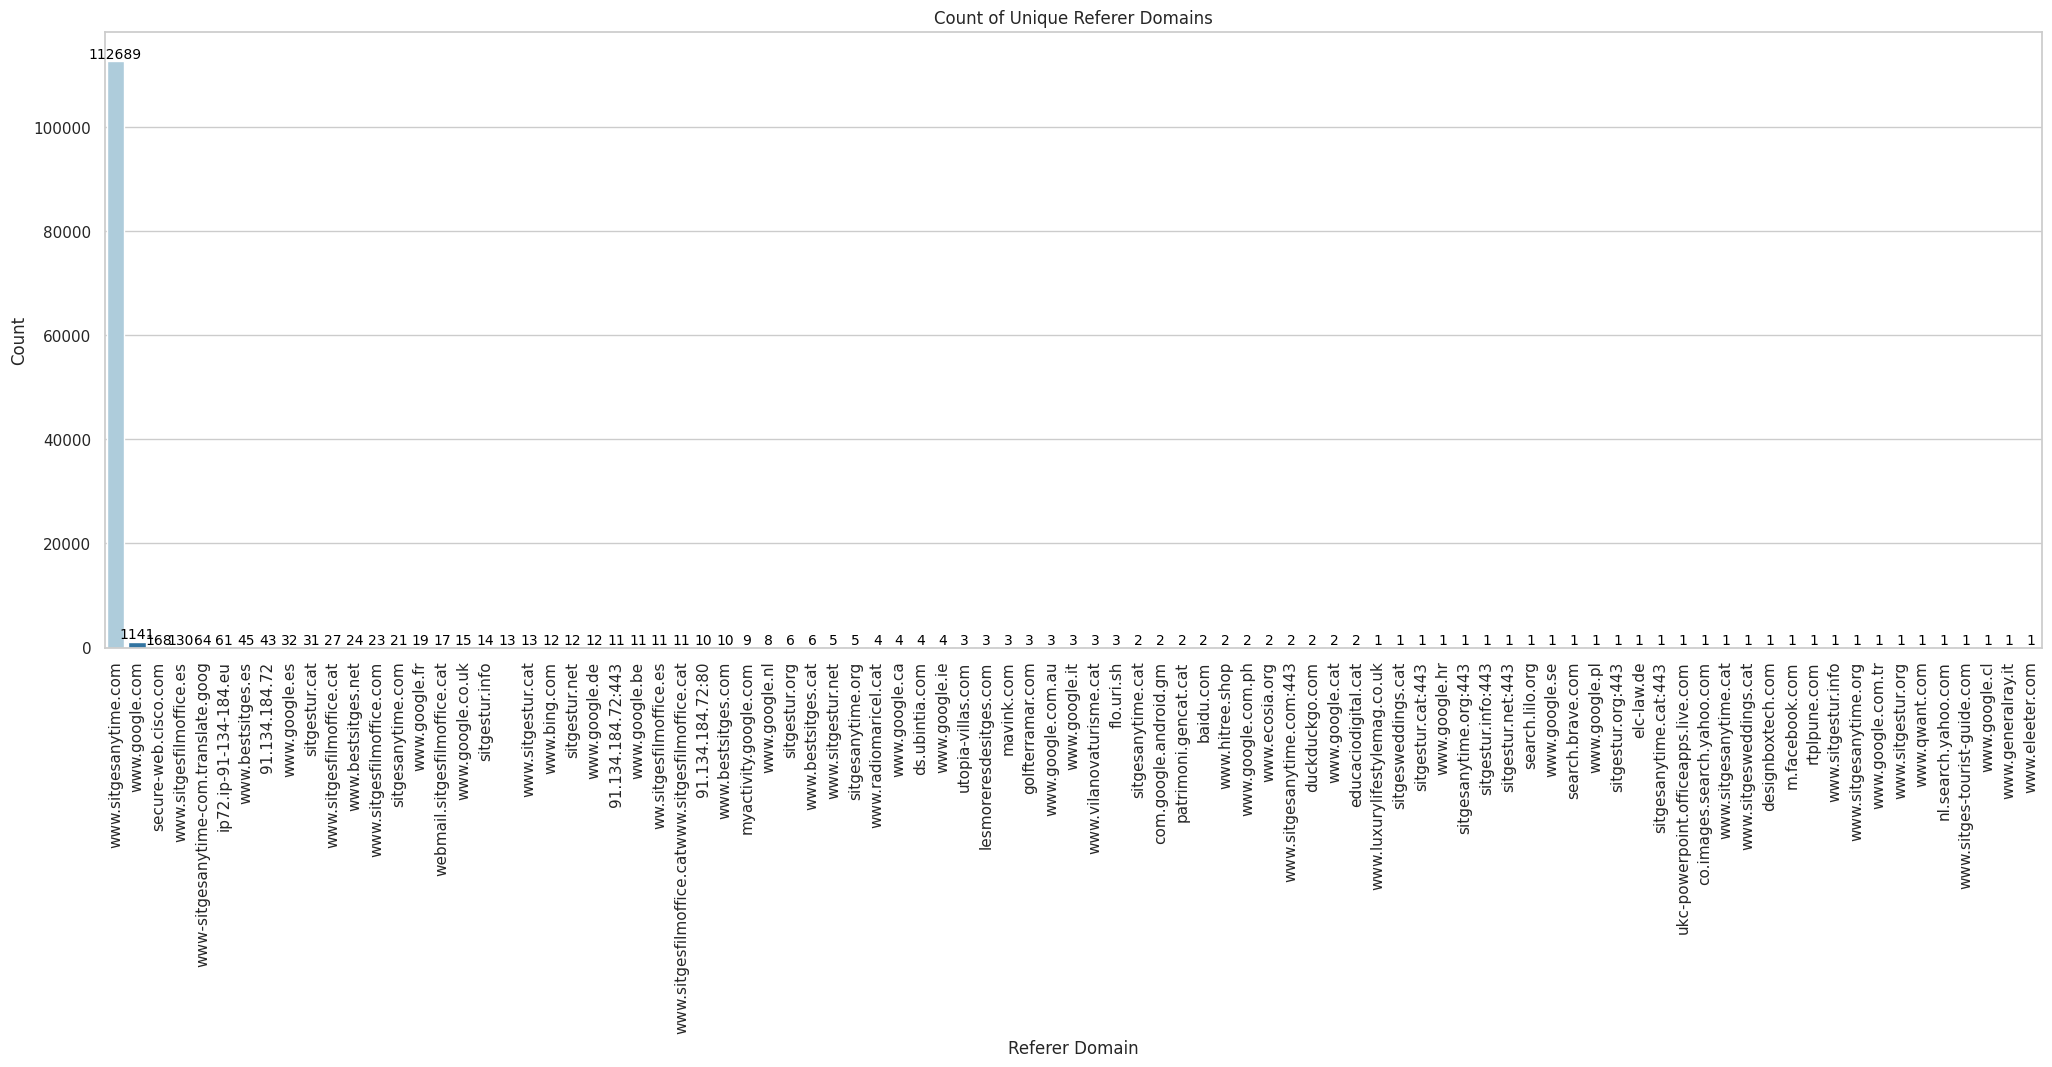

In [ ]:
# Plot domain types
ref_domain_counts = ref_domains.value_counts().astype(int).reset_index()
ref_domain_counts.columns = ['domain', 'count']

sns.set(style="whitegrid")
palette = sns.color_palette("Paired", n_colors=len(ref_domain_counts))

plt.figure(figsize=(25, 8))
ax = sns.barplot(x='domain', y='count', data=ref_domain_counts, palette=palette, hue='domain',legend=False)
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')
plt.xticks(rotation=90)
plt.xlabel('Referer Domain')
plt.ylabel('Count')
plt.title('Count of Unique Referer Domains')
plt.show()

### User agent

In [ ]:
print("Total user agents:",df['user_agent'].notna().sum())

pattern = r"Mozilla/5\.0 \(Windows NT [0-9.]+; Win64; x64\) AppleWebKit/537\.36 \(KHTML, like Gecko\) Chrome/[0-9.]+ Safari/537\.36"
matching_rows = df['user_agent'].str.contains(pattern).sum()
print("Number of matching rows:", matching_rows)

bot_count = df['user_agent'].str.contains("bot", case=False).sum()
print("Number of user_agents containing 'bot':", bot_count)

non_matching_count = (~df['user_agent'].str.contains(pattern, na=False, regex=True)) & (~df['user_agent'].str.contains("bot", case=False, na=False))
print("Number of user agents that don't follow the pattern and don't contain 'bot':", non_matching_count.sum())

Total user agents: 182391
Number of matching rows: 59284
Number of user_agents containing 'bot': 87735
Number of user agents that don't follow the pattern and don't contain 'bot': 35515


In [ ]:
non_matching_ua = df[~df['user_agent'].str.contains(pattern, na=False, regex=True) & ~df['user_agent'].str.contains("bot", case=False, na=False)]

contain_awk = non_matching_ua['user_agent'].str.contains("AppleWebKit", na=False).sum()
print("Contain AppleWebKit:",contain_awk)

no_awk = len(non_matching_ua[~non_matching_ua['user_agent'].str.contains("AppleWebKit", na=False)])
print("Don't contain AppleWebKit:", no_awk)

Contain AppleWebKit: 32664
Don't contain AppleWebKit: 2851


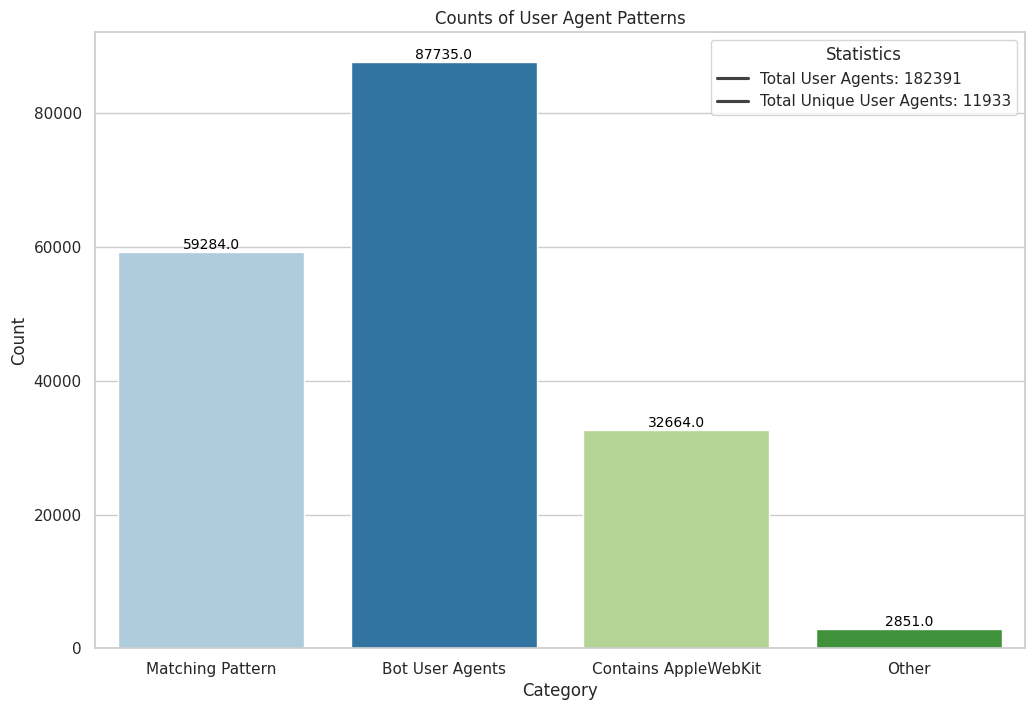

In [ ]:
# Plot User Agent patterns
data = {'Category': ['Matching Pattern', 'Bot User Agents', 'Contains AppleWebKit', "Other"],
        'Count': [matching_rows, bot_count, contain_awk, no_awk]}
plot_df = pd.DataFrame(data)

sns.set(style="whitegrid")
palette = sns.color_palette("Paired",4)

plt.figure(figsize=(12, 8))
ax = sns.barplot(x=range(len(plot_df)), y='Count', data=plot_df, palette=palette, hue=range(len(plot_df)), legend=False)
for i, p in enumerate(ax.patches):
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Counts of User Agent Patterns')
plt.xticks(ticks=range(len(plot_df)), labels=plot_df['Category'])
total_ua = df['user_agent'].notna().sum()
total_unique_ua = len(df["user_agent"].unique())
legend_labels = [f'Total User Agents: {total_ua}', f'Total Unique User Agents: {total_unique_ua}']
plt.legend(title='Statistics', labels=legend_labels, loc='upper right')
plt.show()

In [ ]:
from user_agents import parse

unique_user_agent = set()
unique_browsers = set()
unique_os_families = set()
unique_os_versions = set()
unique_devices = set()
unique_device_brand = set()
unique_device_model = set()
start = set()

for ua_string in df['user_agent']:
    if ua_string is not None:
        ua = parse(ua_string)
        if ua is not None:
            unique_user_agent.add(ua)
            start.add(ua_string.split()[0])
        if ua.browser.family:
            unique_browsers.add(ua.browser.family)
        if ua.os.family:
            unique_os_families.add(ua.os.family)
        if ua.os.version_string:
            unique_os_versions.add(ua.os.version_string)
        if ua.device.family:
            unique_devices.add(ua.device.family)
        if ua.device.brand:
            unique_device_brand.add(ua.device.brand)
        if ua.device.model:
            unique_device_model.add(ua.device.model)

# Print unique values
print("Unique user agent:", len(unique_user_agent))
print("Unique Browsers:", len(unique_browsers))
print("Unique OS Families:", len(unique_os_families), ":", unique_os_families)
print("Unique OS Versions:", len(unique_os_versions))
print("Unique Devices:", len(unique_devices))
print("Unique Devices brand:", len(unique_device_brand),":",unique_device_brand)
print("Unique Devices model:", len(unique_device_model))

print("Unique start:",len(start),":",start)

Unique user agent: 182391
Unique Browsers: 74
Unique OS Families: 12 : {'Other', 'OpenBSD', 'Mac OS X', 'Windows', 'Chrome OS', 'Android', 'Windows Phone', 'Linux', 'Gentoo', 'Fedora', 'iOS', 'Ubuntu'}
Unique OS Versions: 80
Unique Devices: 83
Unique Devices brand: 13 : {'Huawei', 'SonyEricsson', 'Generic_Android', 'Generic', 'Nokia', 'Generic_Android_Tablet', 'Google', 'XiaoMi', 'OnePlus', 'Oppo', 'Apple', 'Samsung', 'Spider'}
Unique Devices model: 84
Unique start: 58 : {"'Cloud", 'Chrome', 'com.google.android.apps.searchlite/889769', 'Dalvik/2.1.0', 'PhxBot/0.1', 'Google', 'python-urllib3/1.26.9', 'WhatsApp/2.23.20.0', 'Mozilla/4.0', 'python-requests/2.22.0', 'Go-http-client/1.1', 'python-requests/2.26.0', 'Mozlila/5.0', 'Client/37312', 'Mozilla', 'Pandalytics/1.0', 'Sogou', 'python-requests/2.27.1', 'Linux', 'FeedFetcher-Google;', 'WhatsApp/2.24.1.80', 'LinkedInBot/1.0', 'com.apple.WebKit.Networking/8617.1.17.10.9', 'curl/7.40.0', 'AdsBot-Google', 'WhatsApp/2.23.25.85', 'Twitterbot/

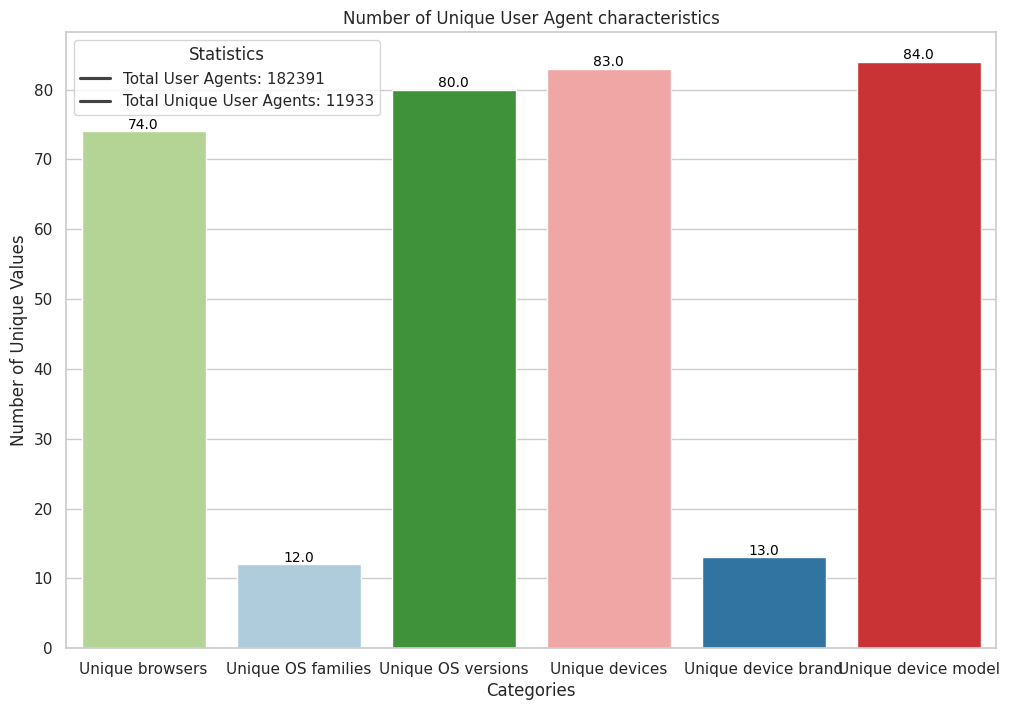

In [ ]:
uniques = [len(unique_browsers),len(unique_os_families),len(unique_os_versions),len(unique_devices),len(unique_device_brand),len(unique_device_model)]
labels = ["Unique browsers","Unique OS families","Unique OS versions","Unique devices","Unique device brand","Unique device model"]

sns.set(style="whitegrid")
palette = sns.color_palette("Paired")

plt.figure(figsize=(12, 8))
ax = sns.barplot(x=labels, y=uniques, palette="Paired",hue=uniques, legend=False)
for p in ax.patches:
    plt.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')
plt.xlabel('Categories')
plt.ylabel('Number of Unique Values')
plt.title('Number of Unique User Agent characteristics')
total_ua = df['user_agent'].notna().sum()
total_unique_ua = len(df["user_agent"].unique())
legend_labels = [f'Total User Agents: {total_ua}', f'Total Unique User Agents: {total_unique_ua}']
plt.legend(title='Statistics', labels=legend_labels, loc='upper left')
plt.show()

##**DATA ENGINEERING**

### Word Embeddings function

In [19]:
# Word embeddings - Word2Vec
def word2vec(raw_corpus, filename):
    corpus = []
    for sentence in raw_corpus:
        if sentence == "unknown":
            corpus.append(["unknown"])
        else:
            words = nltk.word_tokenize(sentence)
            corpus.append(words)

    # Train model
    model = Word2Vec(sentences=corpus, vector_size=100, window=5, min_count=1, workers=4)
    word_vectors = model.wv
    word_vectors.save(f"{filename}.wordvectors")
    wv = KeyedVectors.load(f"{filename}.wordvectors", mmap='r')

    result = []
    for sentence in corpus:
        if sentence == ["unknown"]:
            result.append(0)
        else:
            vectors = [wv[word] for word in sentence]
            sentence_vector = sum(vectors) / len(vectors)
            result.append(np.mean(sentence_vector))

    return result


# Word embeddings - Spacy

# nlp = spacy.load("en_core_web_md") # Load the downloaded model

def log_embeddings(corpus):
    results = []
    for sentence in corpus:
        try:
            words = nltk.word_tokenize(sentence)
        except TypeError:
            results.append(-1)
            print(sentence)
        else:
            vectors = [nlp(word).vector for word in words]
            sentence_vector = sum(vectors) / len(vectors)
            results.append(np.mean(sentence_vector))

    return results

# Word embeddings - FastText

def fast_text(corpus, filename): # Mean of vector

    corpus.to_csv(f'FastText/ft_{filename}.txt', index=False, header=False, encoding='utf-8')

    model = fasttext.train_unsupervised(f'FastText/ft_{filename}.txt', model='skipgram', dim=10)
    #model = fasttext.train_unsupervised(text_data, model='cbow')

    results = []
    for string in corpus:
        try:
            # Get word vector
            vector = model[string]
            # Compute mean and store it
            mean = np.mean(vector)
            results.append(mean)
        except:
            # If value is None
            results.append(-1)

    # Save model
    model.save_model(f"FastText/model_{filename}.bin")

    return results

def fast_text(df, corpus, filename):

    corpus.to_csv(f'FastText/ft_{filename}.txt', index=False, header=False, encoding='utf-8')

    model = fasttext.train_unsupervised(f'FastText/ft_{filename}.txt', model='skipgram', dim=10)
    #model = fasttext.train_unsupervised(text_data, model='cbow')

    vectors = []
    for string in corpus:
        try:
            # Get word vector
            vector = model[string]
            vectors.append(vector)
        except:
            # If value is None
            vectors.append(np.full(50, -1))

    # Convert list of vector to np.array to pandas dataframe
    array = np.array(vectors)
    array_df = pd.DataFrame(array)

    # Add columns names
    array_df.columns = [f'{filename}_{i+1}' for i in range(array_df.shape[1])]

    # Add to dataframe
    df = pd.concat([df, array_df], axis=1)

    # Save model
    model.save_model(f"FastText/model_{filename}.bin")

    return df

In [20]:
# Create folder to store Fast Text models
folder_path = "/content/Identithem/FastText"
if not os.path.exists(folder_path):
    os.makedirs(folder_path)
    print(f"Folder '{folder_path}' created successfully.")
else:
    print(f"Folder '{folder_path}' already exists.")

Folder '/content/Identithem/FastText' already exists.


### Features from IP

In [21]:
def average_time(datetimes):
    # Convert list of datetime strings to datetime objects
    datetimes = [datetime.strptime(dt, '%Y-%m-%d %H:%M:%S%z') for dt in datetimes]
    # Sort the datetime objects
    datetimes.sort()
    # Calculate time differences between consecutive datetimes
    time_diffs = [(datetimes[i + 1] - datetimes[i]).total_seconds() for i in range(len(datetimes) - 1)]
    # Calculate the average time difference
    if len(time_diffs) > 0:
        average_time_diff = sum(time_diffs) / len(time_diffs)
    else:
        average_time_diff = 0

    return average_time_diff

def time_diff(df):
    # Transform to datetime format
    df['datetime'] = pd.to_datetime(df['datetime'])
    # Create dictionary that maps the datetimes of every ip
    ip_datetimes = {}
    for ip, group in df.groupby('ip'):
        ip_datetimes[ip] = list(group['datetime'].astype(str))
    # Store the ips and their average times
    ips = []
    avg_times = []
    for ip, datetimes in ip_datetimes.items():
        avg_time_diff = average_time(datetimes)
        ips.append(ip)
        avg_times.append(avg_time_diff)
    # Create the dataframe
    average_time_diff = pd.DataFrame({'ip': ips, 'average_time': avg_times})

    return average_time_diff

def time_ip_req_diff(df):
    df['datetime'] = pd.to_datetime(df['datetime'], format='%Y-%m-%d %H:%M:%S%z')
    # Save the original order
    df['original_order'] = df.index
    # Sort by IP and datetime to facilitate difference calculation
    df_sorted = df.sort_values(by=['ip', 'datetime'])
    # Calculate the time difference from the last request for the same IP
    df_sorted['sec_since_last_req'] = df_sorted.groupby('ip')['datetime'].diff().dt.total_seconds()
    # Calculate the time difference to the next request for the same IP
    df_sorted['sec_until_next_req'] = df_sorted.groupby('ip')['datetime'].diff(-1).dt.total_seconds().abs()
    # Merge the new columns back to the original DataFrame based on the original order
    df = df.merge(df_sorted[['original_order', 'sec_since_last_req', 'sec_until_next_req']], on='original_order')
    # Drop the helper column used for preserving the order
    df.drop(columns='original_order', inplace=True)
    # Restore the original order
    df = df.sort_index()
    # Fill Nans with -1
    df['sec_since_last_req'].fillna(-1, inplace=True)
    df['sec_until_next_req'].fillna(-1, inplace=True)

    return df

def count_errors(group):
    return (group.isin([401, 403, 404])).sum()

def ip_features(df):
    # Change format of ip (take dots out)
    df['ip'] = df['ip'].str.replace('.', '').astype(int)

    # Is it a bot
    is_bot = df['user_agent'].str.contains('bot|crawl|spider|ZmEu',case=False)
    df['is_bot'] = is_bot.apply(lambda x: 1 if x else 0)

    # Number of requests per ip
    df['n_requests'] = df.groupby('ip')['ip'].transform('count')

    # Map the IP addresses to their corresponding number of bots
    df['n_bots'] = df.groupby('ip')['is_bot'].transform('sum')

    # Number of errors per ip
    df['n_errors'] = df.groupby('ip')['status'].transform(count_errors)

    # Average size per ip
    df['average_size'] = df.groupby('ip')['size'].transform('mean')

    # Average time between requests per ip
    average_time_diff = time_diff(df)
    df["average_timedif"] = df["ip"].map(average_time_diff.set_index('ip')['average_time'])

    # Time in seconds from last and next request of ip
    df = time_ip_req_diff(df)

    # Different user agents per ip
    unique_user_agents_per_ip = df.groupby('ip')['user_agent'].nunique()
    df['n_useragents'] = df['ip'].map(unique_user_agents_per_ip)

    return df


### Features from Datetime

In [22]:
def datetime_features(df):
    # Transform datetime to separate values
    df['datetime'] = pd.to_datetime(df['datetime'])
    df['date_year'] = df['datetime'].dt.year
    df['date_month'] = df['datetime'].dt.month
    df['date_day'] = df['datetime'].dt.day
    df['date_hour'] = df['datetime'].dt.hour
    df['date_minute'] = df['datetime'].dt.minute
    df['date_second'] = df['datetime'].dt.second
    df['date_hourzone'] = df['datetime'].dt.strftime('%z').str[-4:-2]

    return df

### Features from request

In [23]:
def extract_path(request):
    if request == None:
        return None
    path = request.split()[1:-1]
    if len(path) > 0:
        path = path[0]
    else:
        path = "unknown"
    return path

def request_features(df):
    # Fill NaN values with "unknown"
    df["request"].fillna("unknown", inplace=True)

    # Verb from request
    verb_mapping = {'GET': 0, 'POST': 0, 'HEAD': 0}
    req_verb = df["request"].apply(lambda x: x.split()[0] if (x is not None and len(x.split()) > 0) else "unknown")
    df['req_verb'] = req_verb.map(verb_mapping).fillna(1).astype(int)

    # Http version
    http_mapping = {'HTTP/2.0': 0, 'HTTP/1.1': 0}
    req_http = df["request"].apply(lambda x: x.split()[-1] if (x is not None and len(x.split()) > 0) else "unknown")
    df["req_http"] = req_http.map(http_mapping).fillna(1).astype(int)

    # Whole request
    df = fast_text(df, df['request'], filename="request")

    # Reserved words
    reserved_words = ["SELECT","WHERE","JOIN","FROM","NULL","WSO","C99","B374K"]
    df['req_reservedwords'] = df['request'].apply(lambda x: 1 if x is not None and any(word in x for word in reserved_words) else 0)

    return df

### Features from referer

In [24]:
def referer_features(df):
    df["referer"].fillna("unknown", inplace=True)
    df["referer"] = df["referer"].replace("", "unknown")
    df = fast_text(df, df['referer'], filename="referer")
    return df

### Features from user agent

In [25]:
def user_agent_features(df):
    df["user_agent"].fillna("unknown", inplace=True)
    df = fast_text(df, df["user_agent"], filename="useragent")

    return df

### Features from malicious detection

In [26]:
import sys
sys.path.append('/content/Identithem/')

from analyze_request import detectSQLi, detectRFI, detectWebShell

def common_attack_detection(request):
    """
    Checks request for common attacks
    """
    if request == None:
        return 0
    else:
        if detectSQLi(request):
            return 1
        elif detectRFI(request):
            return 1
        elif detectWebShell(request):
            return 1
        else:
            return 0

def blacklist_detection(ip):
    """
    Checks if ip is in blacklist
    """
    if ip in ip_addresses_blacklisted:
        return 1
    else:
        return 0

### Features for Nan values

In [27]:
def has_nan_values(df):
    nan_counts = df.isnull().sum(axis=1)
    df['n_nans'] = nan_counts.apply(lambda x:
                                    1 if x == 1 else
                                    2 if x == 2 else
                                    3 if x == 3 else
                                    0)
    return df

### Add new features to df

In [28]:
def add_features(df):
  # Drop empty columns
  df = df.drop(['client', 'user'], axis=1)
  # Number of nan values
  df = has_nan_values(df)

  df = ip_features(df)
  print("Features from ip added.")
  df = datetime_features(df)
  print("Features from datetime added.")
  df = request_features(df)
  print("Features from request added.")
  df = referer_features(df)
  print("Features from referer added.")
  df = user_agent_features(df)
  print("Features from user_agent added.")

  # Other
  # Is a common attack
  df['is_attack'] = df['request'].apply(common_attack_detection)
  # Is in blacklist
  df['is_blacklist'] = df['ip'].apply(blacklist_detection)

  return df


## **DATA EXPLORATION II**

Data analysis after the creation of new features

In [ ]:
df = parse_log('/content/Identithem/Sitges Logs/sitges_access.20240122.log')
df_X = add_features(df)

Features from ip added.
Features from datetime added.
Features from request added.
Features from referer added.
Features from user_agent added.


In [ ]:
df_X.dtypes

ip                                        int64
datetime              datetime64[ns, UTC+01:00]
request                                  object
status                                    int64
size                                      int64
referer                                  object
user_agent                               object
n_nans                                    int64
is_bot                                    int64
n_requests                                int64
n_bots                                    int64
n_errors                                  int64
average_size                            float64
average_timedif                         float64
sec_since_last_req                      float64
sec_until_next_req                      float64
n_useragents                              int64
date_year                                 int32
date_month                                int32
date_day                                  int32
date_hour                               

In [ ]:
df_X.isna().sum()

ip                    0
datetime              0
request               0
status                0
size                  0
referer               0
user_agent            0
n_nans                0
is_bot                0
n_requests            0
n_bots                0
n_errors              0
average_size          0
average_timedif       0
sec_since_last_req    0
sec_until_next_req    0
n_useragents          0
date_year             0
date_month            0
date_day              0
date_hour             0
date_minute           0
date_second           0
date_hourzone         0
req_verb              0
req_path_we           0
req_http              0
request_we            0
req_reservedwords     0
referer_we            0
useragent_we          0
is_attack             0
is_blacklist          0
dtype: int64

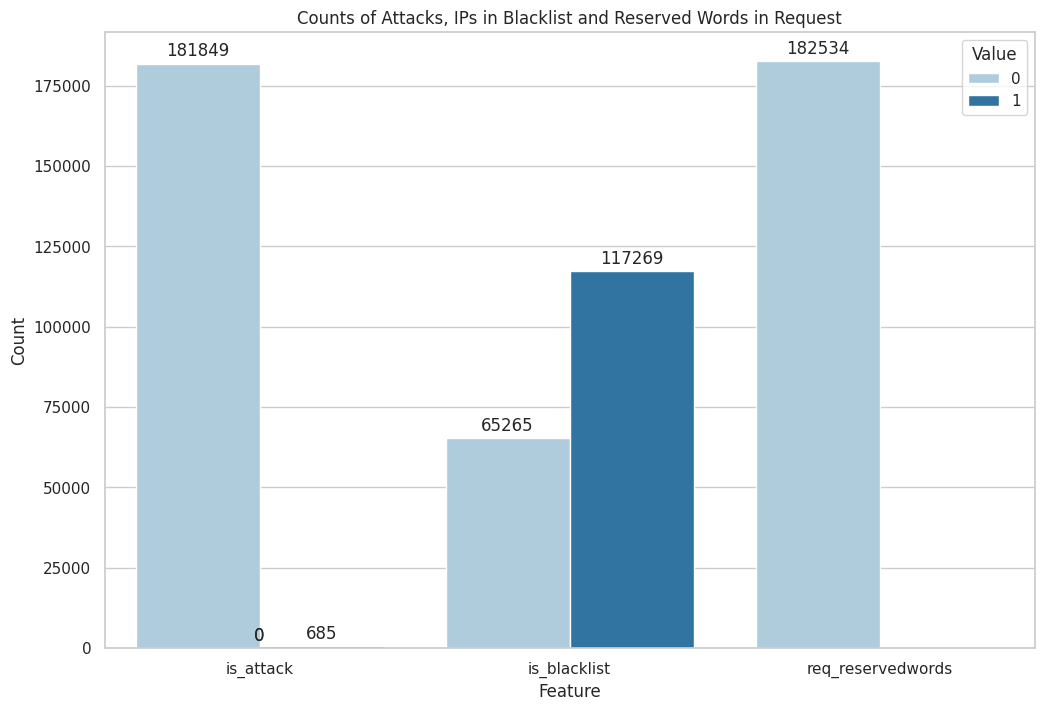

In [ ]:
# Plot for is_attack, is_blacklist, req_reservedwords

# Count the values for each column
count_is_attack = df_X['is_attack'].value_counts().sort_index()
count_is_blacklist = df_X['is_blacklist'].value_counts().sort_index()
count_req_reservedwords = df_X['req_reservedwords'].value_counts().sort_index()

# Create a DataFrame for plotting
plot_data = pd.DataFrame({
    'is_attack': count_is_attack,
    'is_blacklist': count_is_blacklist,
    'req_reservedwords': count_req_reservedwords
}).reset_index().melt(id_vars='index', var_name='Feature', value_name='Count')

# Create the bar plot
plt.figure(figsize=(12, 8))
sns.set_palette('Paired')
barplot = sns.barplot(x='Feature', y='Count', hue='index', data=plot_data)

# Add count labels on top of each bar
for p in barplot.patches:
    barplot.annotate(format(p.get_height(), '.0f'),
                     (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha = 'center', va = 'center',
                     xytext = (0, 9),
                     textcoords = 'offset points')

# Customize the plot
plt.title('Counts of Attacks, IPs in Blacklist and Reserved Words in Request')
plt.xlabel('Feature')
plt.ylabel('Count')
plt.legend(title='Value', loc='upper right')

# Show the plot
plt.show()

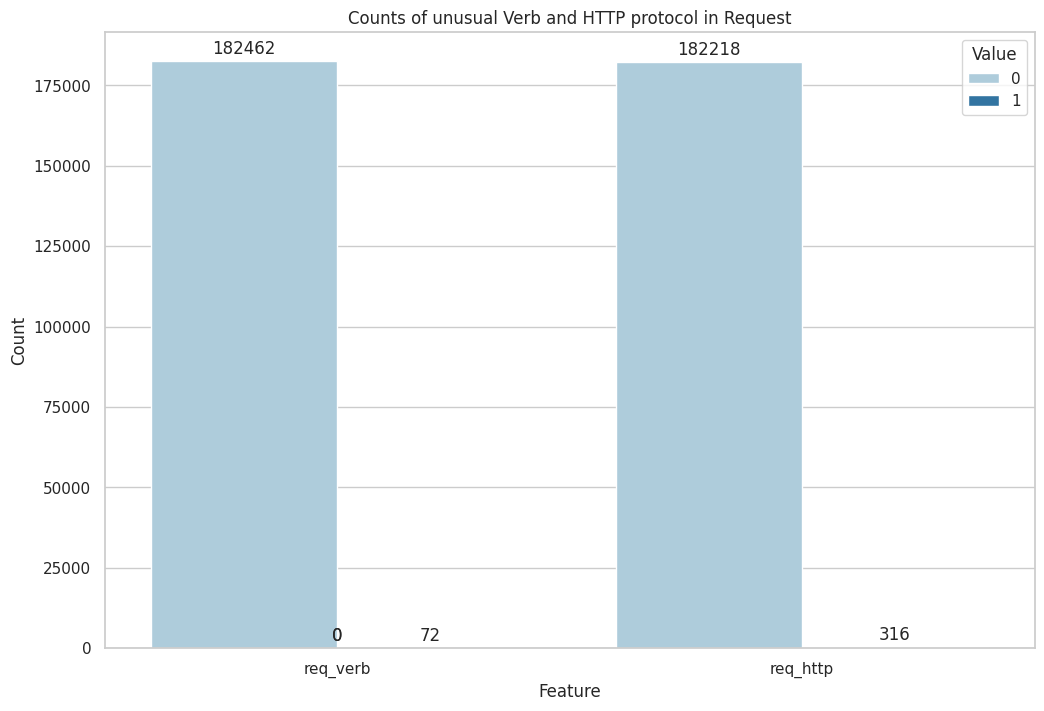

In [ ]:
# Plot for req_verb, req_http

# Count the values for each column
count_verb = df_X['req_verb'].value_counts().sort_index()
count_http = df_X['req_http'].value_counts().sort_index()

# Create a DataFrame for plotting
plot_data = pd.DataFrame({
    'req_verb': count_verb,
    'req_http': count_http,
}).reset_index().melt(id_vars='index', var_name='Feature', value_name='Count')

# Create the bar plot
plt.figure(figsize=(12, 8))
sns.set_palette('Paired')
barplot = sns.barplot(x='Feature', y='Count', hue='index', data=plot_data)

# Add count labels on top of each bar
for p in barplot.patches:
    barplot.annotate(format(p.get_height(), '.0f'),
                     (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha = 'center', va = 'center',
                     xytext = (0, 9),
                     textcoords = 'offset points')

# Customize the plot
plt.title('Counts of unusual Verb and HTTP protocol in Request')
plt.xlabel('Feature')
plt.ylabel('Count')
plt.legend(title='Value', loc='upper right')

# Show the plot
plt.show()

<Figure size 1200x800 with 0 Axes>

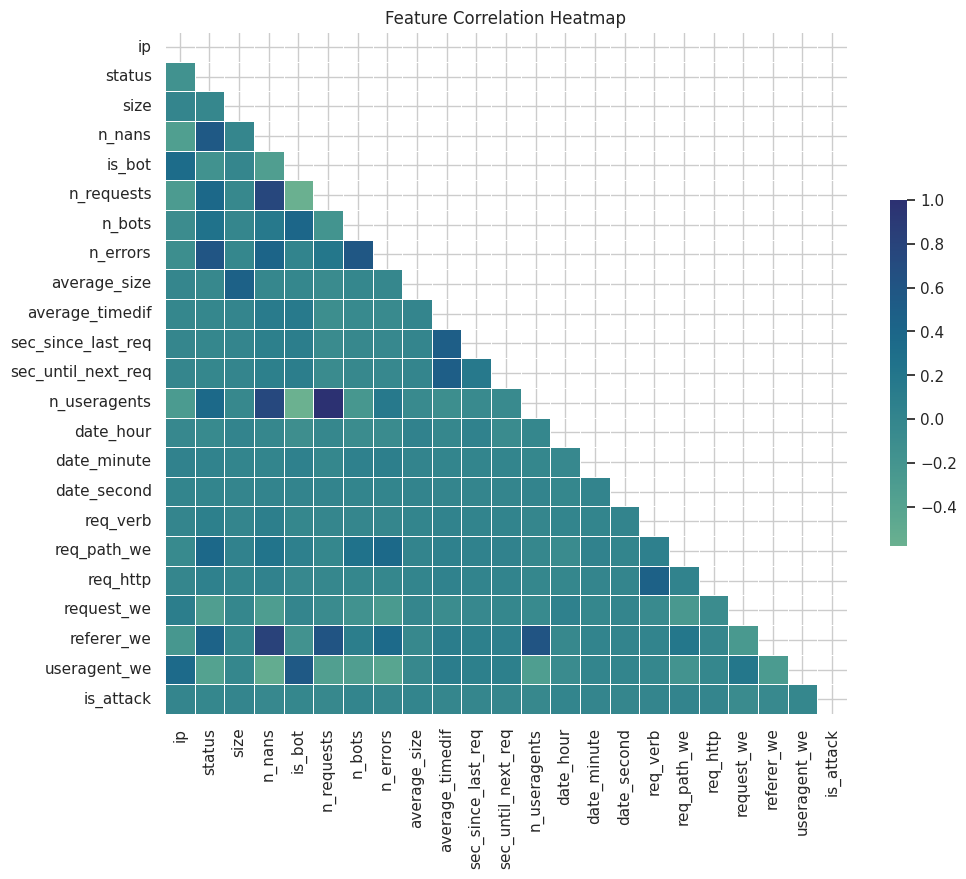

In [ ]:
# Plot correlation matrix
columns = df_X.columns.tolist()
chosen_cols = ['ip','status','size','n_nans','is_bot','n_requests','n_bots','n_errors','average_size',
               'average_timedif','sec_since_last_req','sec_until_next_req','n_useragents',
               'date_hour','date_minute','date_second','req_verb','req_http','is_attack', 'is_blacklist'] #is_blacklist, req_reservedwords

selected_features = [feature for feature in columns if feature in chosen_cols]
corr_matrix = df_X[selected_features].corr()

plt.figure(figsize=(12, 8))

mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.color_palette("crest", as_cmap=True)
sns.heatmap(corr_matrix, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title("Feature Correlation Heatmap")
plt.show()

## Obtain final datasets

In [29]:
chosen_cols = ['ip','status','size','n_nans','is_bot','n_requests','n_bots','n_errors','average_size',
               'average_timedif','sec_since_last_req','sec_until_next_req','n_useragents',
               'date_month','date_day','date_hour','date_minute','date_second',
               'req_verb','req_http','request_we','referer_we','useragent_we',
               'is_attack','is_blacklist'] #req_reservedwords

delete_cols = ['datetime','request','referer','user_agent','date_year','date_hourzone','req_reservedwords']

In [30]:
def print_header(file):
    print("------------------------------------------------")
    print(f"Preprocessing file {file}...")
    print("------------------------------------------------")

In [31]:
dfs = {}
for file in os.listdir("/content/Identithem/Sitges Logs/"):
    print_header(file)
    df = parse_log(f'/content/Identithem/Sitges Logs/{file}')
    df_X = add_features(df)
    final_df = df_X.drop(columns=delete_cols).copy()
    dfs[file[14:-4]] = [df_X, final_df]
    final_df.to_csv(f'preprocessed_data/logs_{file[14:-4]}.csv', index=False)

------------------------------------------------
Preprocessing file sitges_access.20240129.log...
------------------------------------------------
Features from ip added.
Features from datetime added.
Features from request added.
Features from referer added.
Features from user_agent added.
------------------------------------------------
Preprocessing file sitges_access.20240124.log...
------------------------------------------------
Features from ip added.
Features from datetime added.
Features from request added.
Features from referer added.
Features from user_agent added.
------------------------------------------------
Preprocessing file sitges_access.20240123.log...
------------------------------------------------
Features from ip added.
Features from datetime added.
Features from request added.
Features from referer added.
Features from user_agent added.
------------------------------------------------
Preprocessing file sitges_access.20240127.log...
-----------------------------

In [32]:
print(dfs['20240122'][1].columns.tolist())

['ip', 'status', 'size', 'n_nans', 'is_bot', 'n_requests', 'n_bots', 'n_errors', 'average_size', 'average_timedif', 'sec_since_last_req', 'sec_until_next_req', 'n_useragents', 'date_month', 'date_day', 'date_hour', 'date_minute', 'date_second', 'req_verb', 'req_http', 'request_1', 'request_2', 'request_3', 'request_4', 'request_5', 'request_6', 'request_7', 'request_8', 'request_9', 'request_10', 'referer_1', 'referer_2', 'referer_3', 'referer_4', 'referer_5', 'referer_6', 'referer_7', 'referer_8', 'referer_9', 'referer_10', 'useragent_1', 'useragent_2', 'useragent_3', 'useragent_4', 'useragent_5', 'useragent_6', 'useragent_7', 'useragent_8', 'useragent_9', 'useragent_10', 'is_attack', 'is_blacklist']


In [34]:
dfs['20240122'][1]

,ip,status,size,n_nans,is_bot,n_requests,n_bots,n_errors,average_size,average_timedif,...,useragent_3,useragent_4,useragent_5,useragent_6,useragent_7,useragent_8,useragent_9,useragent_10,is_attack,is_blacklist
0,47763519,301,4840,1,0,45227,0,279,5288.314945,1.909521,...,-0.532672,0.347932,0.025485,-0.377279,0.444883,-0.211238,0.110871,0.346352,0,1
1,47763519,200,5223,1,0,45227,0,279,5288.314945,1.909521,...,-0.532672,0.347932,0.025485,-0.377279,0.444883,-0.211238,0.110871,0.346352,0,1
2,407716753,404,2509,1,1,34,34,3,17878.264706,2600.060606,...,-1.270255,0.511313,1.425363,-0.525393,-0.021154,-0.198169,1.027196,1.306700,0,0
3,47763519,301,4840,1,0,45227,0,279,5288.314945,1.909521,...,-0.576494,0.373287,0.069758,-0.384001,0.411240,-0.268480,0.155846,0.336794,0,1
4,47763519,200,5260,1,0,45227,0,279,5288.314945,1.909521,...,-0.576494,0.373287,0.069758,-0.384001,0.411240,-0.268480,0.155846,0.336794,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182529,16811968184,200,717,0,1,375,375,0,11601.168000,221.082888,...,-0.796326,0.422402,2.075582,1.881311,0.996846,-0.637943,1.005306,0.685913,0,1
182530,16811968184,200,454,0,1,375,375,0,11601.168000,221.082888,...,-0.796326,0.422402,2.075582,1.881311,0.996846,-0.637943,1.005306,0.685913,0,1
182531,16811968184,200,4825,0,1,375,375,0,11601.168000,221.082888,...,-0.796326,0.422402,2.075582,1.881311,0.996846,-0.637943,1.005306,0.685913,0,1
182532,5270240171,200,14196,1,1,726,726,35,138743.340220,12.631724,...,-0.309739,0.678957,-0.054875,0.132896,0.347127,1.029242,1.298182,-0.295300,0,1


Download separate files

In [33]:
from google.colab import files

filenames = ["20240122","20240123","20240124","20240125","20240126","20240127","20240128","20240129"]
for file in filenames:
    files.download(f'preprocessed_data/logs_{file}.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Merge the dataframes in a single one

In [44]:
filenames = ["20240123","20240124","20240125","20240126"]

df_final_list = []
for file in filenames:
    df_final_list.append(dfs[file][1])

merged_final_df = pd.concat(df_final_list, axis=0).reset_index(drop=True)
merged_final_df.to_csv(f'preprocessed_logs.csv', index=False)

In [46]:
merged_final_df

,ip,status,size,n_nans,is_bot,n_requests,n_bots,n_errors,average_size,average_timedif,...,useragent_3,useragent_4,useragent_5,useragent_6,useragent_7,useragent_8,useragent_9,useragent_10,is_attack,is_blacklist
0,92184116229,200,89277,0,0,1,0,0,89277.000000,0.000000,...,-0.131792,0.057407,-1.024031,-0.085928,0.444957,0.594385,-0.485778,-0.169227,0,0
1,232235162,200,17495,1,1,1,1,0,17495.000000,0.000000,...,-0.144904,0.103771,-0.631678,-0.300106,0.596657,0.154318,-0.110610,-0.058226,0,1
2,662497099,304,6170,1,1,251,251,11,59458.462151,335.780000,...,-1.031193,1.015346,-0.045354,-1.402270,0.874216,0.195861,0.005949,0.107801,0,0
3,6624970164,301,538,1,1,2,2,0,536.000000,4521.000000,...,-0.595293,1.408507,0.194570,-1.609530,0.682904,0.323498,0.451693,-0.088080,0,0
4,6624970163,301,518,1,1,3,3,0,530.666667,15621.500000,...,-0.681837,1.116640,-0.264935,-0.886558,0.086097,0.249921,0.049014,0.127765,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
557498,6624964166,200,14424,1,1,16,16,1,44885.187500,5010.666667,...,0.448979,0.186819,0.906540,0.414332,0.438899,0.884260,0.412479,0.656366,0,0
557499,6624964164,200,828,0,1,19,19,0,248234.736842,4175.777778,...,0.448979,0.186819,0.906540,0.414332,0.438899,0.884260,0.412479,0.656366,0,0
557500,662497097,200,37225,0,1,3133,3132,26,11735.681455,27.154215,...,0.448979,0.186819,0.906540,0.414332,0.438899,0.884260,0.412479,0.656366,0,0
557501,16221615071,301,537,1,0,2,0,0,30800.500000,0.000000,...,-0.574904,0.011197,0.268644,0.331469,0.870916,-0.427118,0.030409,0.603163,0,0


Download all dataframes combined

In [45]:
files.download(f'preprocessed_logs.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Combine all loglines in a single dataframe with index-log columns

In [60]:
def create_logs_df(file):
  data = []
  with open("/content/Identithem/Sitges Logs/"+file) as fp:
    lines = []
    for line in fp:
      lines.append(line)

  df = pd.DataFrame(lines, columns=['logline'])
  return df

In [61]:
filenames = ["sitges_access.20240123.log", "sitges_access.20240124.log", "sitges_access.20240125.log", "sitges_access.20240126.log"]

dfs_loglines = []

for file in os.listdir("/content/Identithem/Sitges Logs/"):
    if file in filenames:
        df = create_logs_df(file)
        dfs_loglines.append(df)

In [62]:
merged_loglines = pd.concat(dfs_loglines, axis=0).reset_index(drop=True)
merged_loglines.to_csv(f'loglines_index.csv', index=False)

In [63]:
merged_loglines

,logline
0,www.sitgesanytime.com 54.36.148.84 - - [24/Jan...
1,www.sitgesanytime.com 168.119.68.125 - - [24/J...
2,www.sitgesanytime.com 168.119.68.125 - - [24/J...
3,www.sitgesanytime.com 168.119.68.125 - - [24/J...
4,www.sitgesanytime.com 168.119.68.125 - - [24/J...
...,...
557498,www.sitgesanytime.com 111.225.149.144 - - [25/...
557499,www.sitgesanytime.com 111.225.149.144 - - [25/...
557500,www.sitgesanytime.com 54.36.149.34 - - [25/Jan...
557501,www.sitgesanytime.com 54.36.149.78 - - [25/Jan...


In [64]:
files.download(f'loglines_index.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>